In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

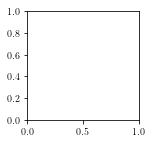

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
def get_major_fre(*arg, **kwargs):
    return spf_tb.get_major_fre(*arg, **kwargs)
    
def load_rand_data_pickle_dir_v3(t_dir, t_headle='(.*?).pickle', n_load=None, rand_mode=False, 
                                 add_info=False): 
    t_path = os.listdir(t_dir)
    filename_list = [filename for filename in t_path if re.match(t_headle, filename) is not None]
    wt_list = []
    pickle_path_list = []
    mean_eta_list = []
    std_psi_list = []
    dx_list = []
    dy_list = []
    dz_list = []
    dpsi_list = []
    
    n_load = len(filename_list) if n_load is None else n_load
    assert n_load <= len(filename_list)
    if rand_mode:
        tidx = np.random.choice(len(filename_list), n_load, replace=False)
    else:
        tidx = np.arange(n_load)
    use_filename_list = np.array(filename_list)[tidx]

    for tname in use_filename_list:
        tpath = os.path.join(t_dir, tname)
        with open(tpath, 'rb') as handle:
                tpick = pickle.load(handle)
        wt_list.append(tpick['omega_tail'])
        pickle_path_list.append(tpath)

        # fft rule
        tx = tpick['Table_t']
        tmin = np.max((0, tx.max() - 1000))
        idx = tx > tmin
        freq_pk = get_major_fre(tx[idx], tpick['Table_theta'][idx])
        idx = tx > (tx.max() - 1 / freq_pk * 10)
        mean_eta_list.append(np.mean(tpick['Table_eta'][idx]))
        std_psi_list.append((np.mean(tpick['Table_psi'][idx]), np.std(tpick['Table_psi'][idx])))
        for i0, tlist in enumerate((dx_list, dy_list, dz_list)):
            tpoly = np.polyfit(tx[idx], tpick['Table_X'][idx, i0], 1, w=np.blackman(idx.sum()))
            tlist.append(tpoly[0])
        dpsi_list.append(np.polyfit(tx[idx], spf_tb.get_increase_angle(tpick['Table_psi'][idx]), 
                                    deg=1, w=np.blackman(idx.sum()))[0])

    wt_list = np.hstack(wt_list)
    pickle_path_list = np.array(pickle_path_list)
    mean_eta_list = np.hstack(mean_eta_list)
    std_psi_list = np.array(std_psi_list)
    dx_list = np.hstack(dx_list)
    dy_list = np.hstack(dy_list)
    dz_list = np.hstack(dz_list)
    dpsi_list = np.hstack(dpsi_list)
    if add_info:
        return dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, \
                (std_psi_list, dpsi_list)
    else: 
        return dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list


In [4]:
n_load = None
rand_mode=False
# job_dir_list = ['ecoC01B05_inithphps_a', 
#                 'ecoC01B05_inithphps_c']
# job_dir_list = ['ecoC01B05_inithphps_g', 
#                 'ecoC01B05_inithphps_h']
job_dir_list = ['ecoC01B05_inithphps_a', 
                'ecoC01B05_inithphps_c', 
                'ecoC01B05_inithphps_g', 
                'ecoC01B05_inithphps_h', 
                'ecoC01B05_inithphps_i', ]
# job_dir_list = ['ecoC01B05_inithphps_f', ]
# job_dir_list = ['ecoC01B05_inithphps_g', ]
t_headle = '(.*?).pickle'
data_list = []
pickle_name = '%s.pickle' % 'ecoC01B05_data_list'

for job_dir in job_dir_list:
    use_dir = os.path.join(os.getcwd(), job_dir)
    dir_list = [o for o in os.listdir(use_dir) if (os.path.isdir(os.path.join(use_dir, o)) 
                                                   and not o.startswith('.'))]
    print(use_dir)
    for sub_dir in tqdm_notebook(dir_list[:]):
        t_dir = os.path.join(use_dir, sub_dir)
        data_list.append(load_rand_data_pickle_dir_v3(t_dir, t_headle, n_load=n_load, rand_mode=rand_mode, 
                                                      add_info=True))
    # data_list = np.array(data_list)
    
with open(pickle_name, 'wb') as handle:
    pickle.dump(data_list, handle, protocol=4)

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a



/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_c



/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_g



/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h



/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_i


In [7]:
pickle_name = '%s.pickle' % 'ecoC01B05_data_list'
with open(pickle_name, 'rb') as handle:
    data_list = pickle.load(handle)

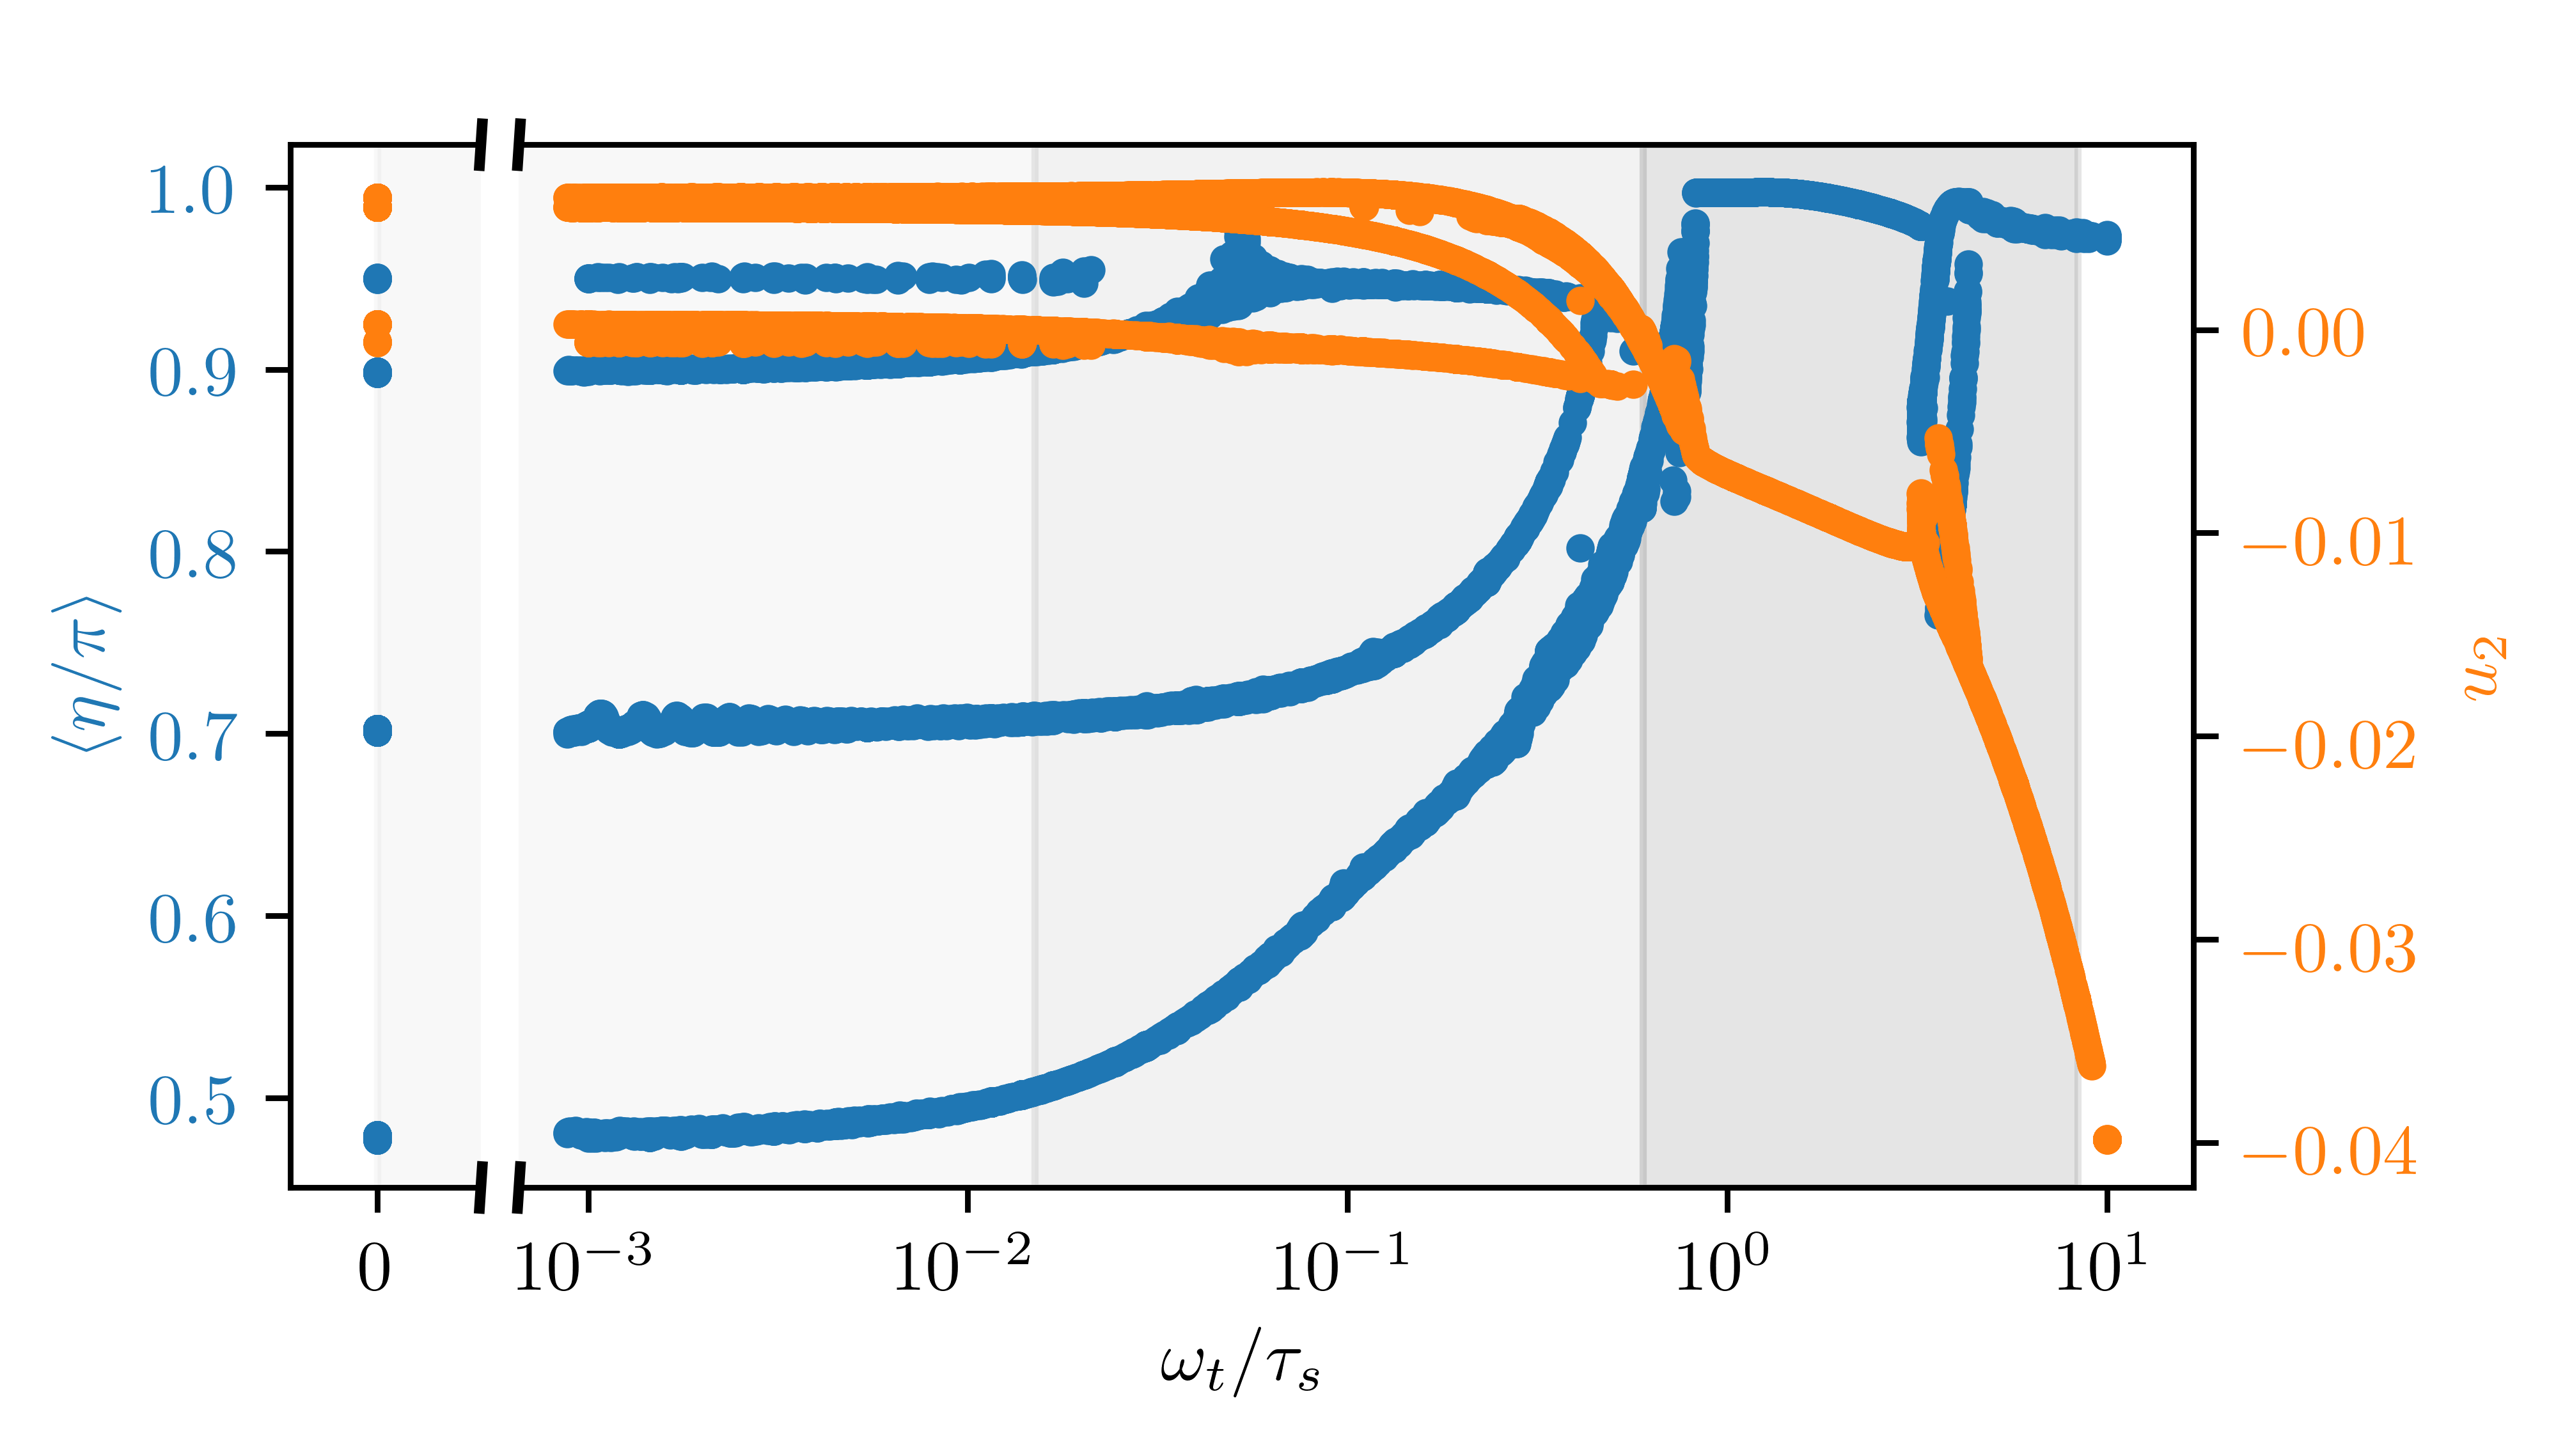

In [10]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.3
dpi = 800 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5
color0 = 'C0'
color1 = 'C1'

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.1, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.1)))

axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.1, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)
axi1 = fig.add_axes(axi_pos)
axi2 = axi1.twinx()
axi1.tick_params(axis='y', labelcolor=color0)
axi2.tick_params(axis='y', labelcolor=color1)

for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    axi1.plot(wt_list[tidx], mean_eta_list[tidx] / np.pi, '.', color=color0, label='')
    axi2.plot(wt_list[tidx], dy_list[tidx], '.', color=color1)
axi1.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi2.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi1.patch.set_alpha(0)
axi1.set_xlabel('$\\omega_t / \\tau_s$')
axi1.set_ylabel('$\\langle \\eta / \\pi \\rangle$', color=color0)
axi2.set_ylabel('$u_2$', color=color1)
for t1 in axi1.spines:
    axi1.spines[t1].set_visible(False)
for t1 in axi2.spines:
    axi2.spines[t1].set_visible(False)

axi.set_xlim(axi1.get_xlim())
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.tick_params(axis=u'both', which=u'both',length=0)
axi.set_xticklabels([])
axi.set_yticklabels([])
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
# plt.tight_layout()

(-0.00041000000000000005, 16.895761786607743) (0.450762555738113, 1.0233176572262268)


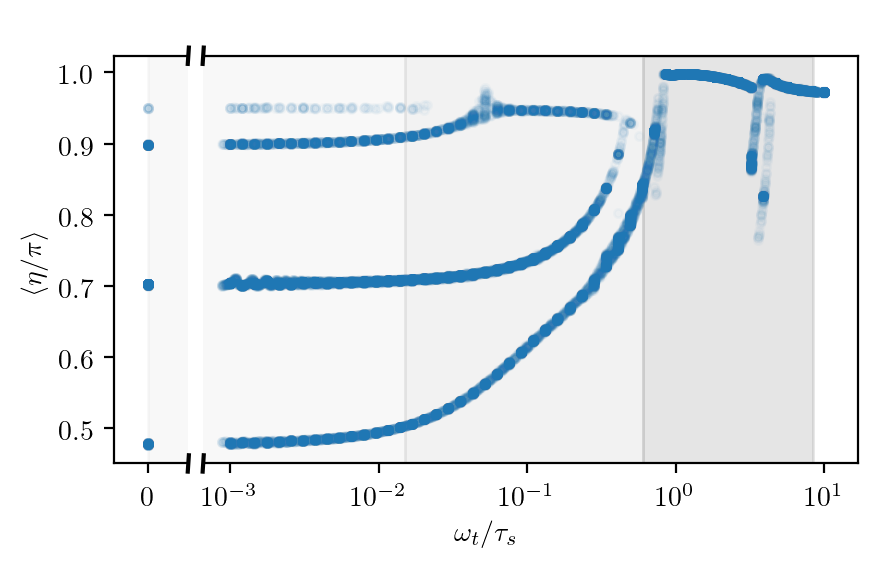

In [11]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.3
dpi = 200 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.1, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.1)))

axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.1, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)
axi1 = fig.add_axes(axi_pos)

for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    axi1.plot(wt_list[tidx], mean_eta_list[tidx] / np.pi, '.C0', alpha=0.03)
axi1.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi1.patch.set_alpha(0)
axi1.set_xlabel('$\\omega_t / \\tau_s$')
axi1.set_ylabel('$\\langle \\eta / \\pi \\rangle$')
for t1 in axi1.spines:
    axi1.spines[t1].set_visible(False)

axi.set_xlim(axi1.get_xlim())
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.tick_params(axis=u'both', which=u'both',length=0)
axi.set_xticklabels([])
axi.set_yticklabels([])
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
print(axi1.get_xlim(), axi1.get_ylim())

(-0.5, 10.5) (-0.042214619578067714, 0.009102998752576811)


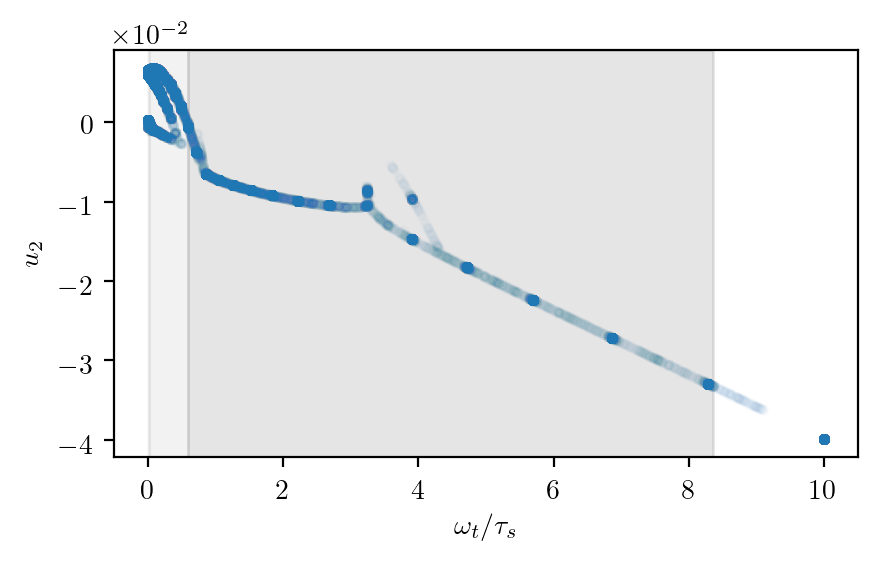

In [12]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.3
dpi = 200 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.1, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.1)))

# axi3 = fig.add_axes(axi_pos + dpos)
# axi3.set_xticklabels([])
# axi3.set_yticklabels([])
# for t1 in axi3.spines:
#     axi3.spines[t1].set_visible(False)
# axi3.tick_params(axis=u'both', which=u'both',length=0)
# dpos = np.array(((axi_pos[2] * 0.1, 0, axi_pos[2] * -0.98, 0)))
# axi4 = fig.add_axes(axi_pos + dpos)
# axi4.set_xticklabels([])
# axi4.set_yticklabels([])
# for t1 in axi4.spines:
#     axi4.spines[t1].set_visible(False)
# axi4.tick_params(axis=u'both', which=u'both',length=0)
# td = 0.02 # how big to make the diagonal lines in axes coordinates
# kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
# axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
# axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

axi1 = fig.add_axes(axi_pos)
for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    axi1.plot(wt_list[tidx], dy_list[tidx], '.C0', alpha=0.01)
# axi1.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi1.patch.set_alpha(0)
axi1.set_xlabel('$\\omega_t / \\tau_s$')
axi1.set_ylabel('$u_2$')
for t1 in axi1.spines:
    axi1.spines[t1].set_visible(False)
axi1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

axi.set_xlim(axi1.get_xlim())
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.tick_params(axis=u'both', which=u'both',length=0)
axi.set_xticklabels([])
axi.set_yticklabels([])
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
print(axi1.get_xlim(), axi1.get_ylim())

In [84]:
len(data_list)

450

0.811598 0.4284471148484675
3.237458 0.8865872469340671


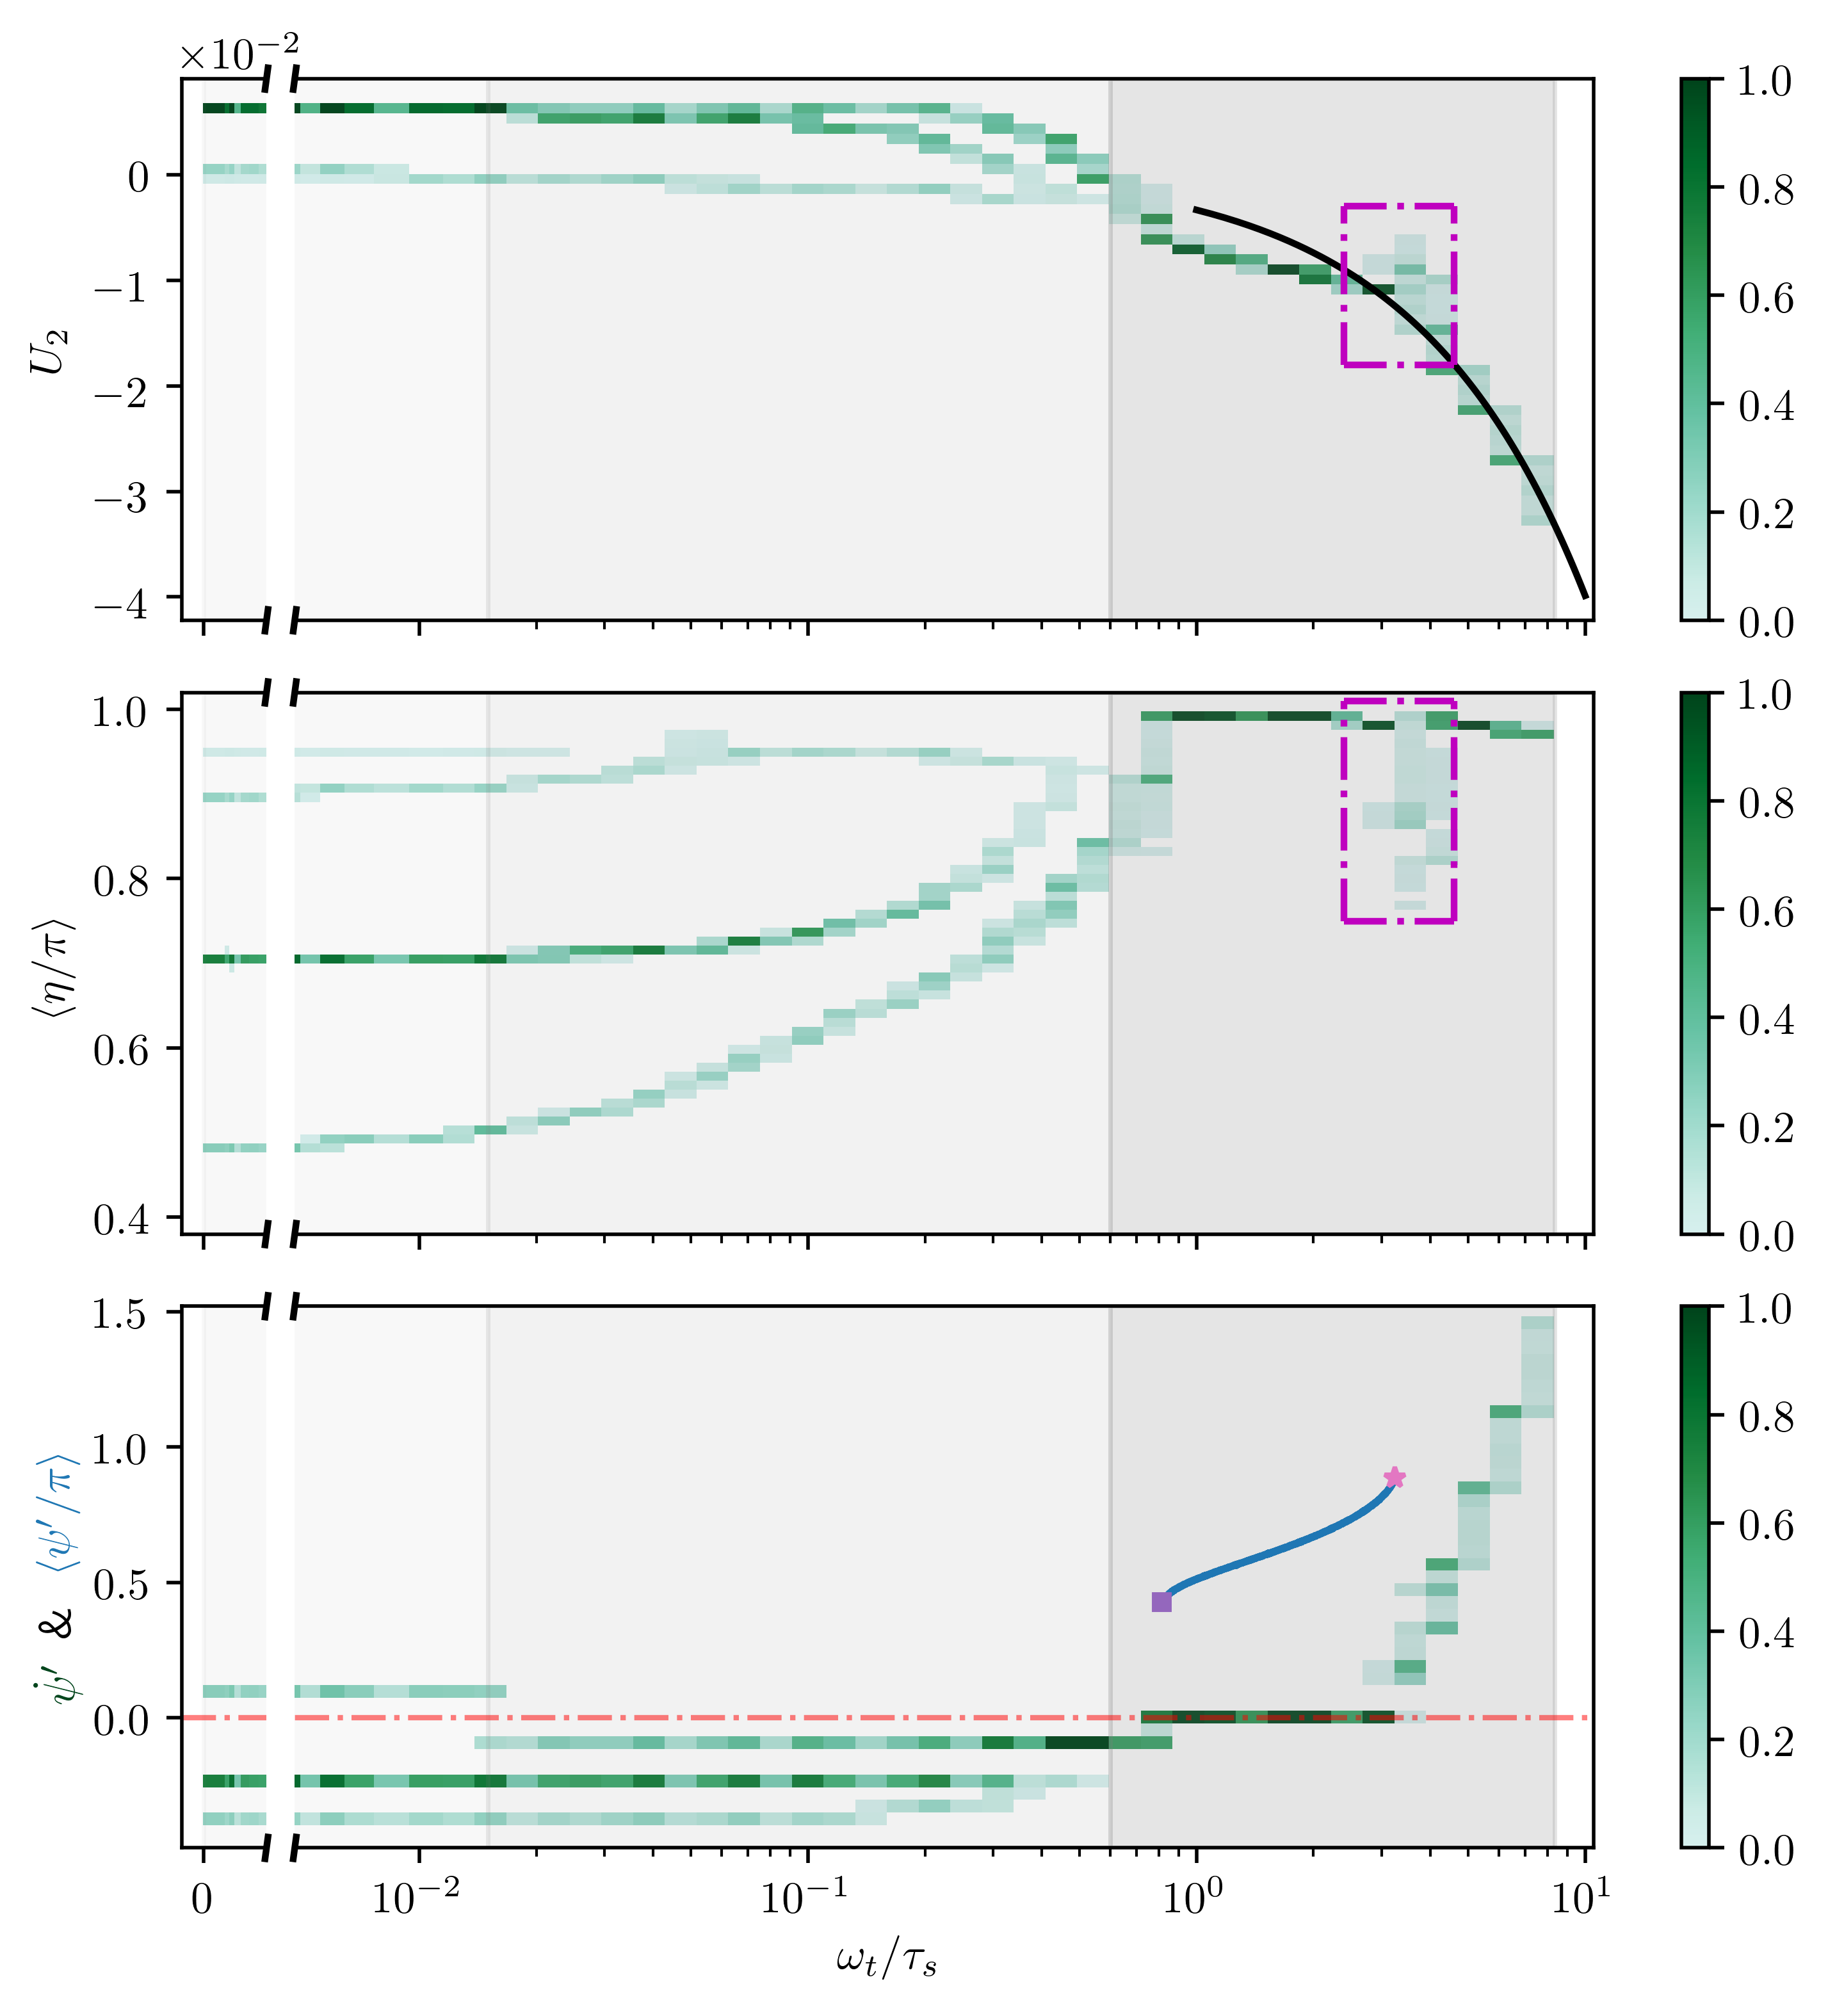

In [29]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import colorbar
from matplotlib import colors as mcolors

# figsize = np.array((16, 9)) * 0.4
figsize = np.array((16, 16)) * 0.4
markersize = 6
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
tcolors = np.vstack(((1, 1, 1, 1), plt.get_cmap('BuGn')(np.linspace(0.2, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', tcolors)
# norm = mcolors.LogNorm()
norm = mcolors.Normalize(vmin=0, vmax=1)

# xlim = (-0.0001, 115)
# ylim0 = (-0.43, 0.05)
# ylim1 = (0.45, 1.02)

xlim = (-0.001, 10.5)
linthreshx, linscalex = 1e-2,  0.5
ylim0 = (-0.04221, 0.00910)
nyaxis0 = 50
ylim1 = (0.38, 1.02)
nyaxis1 = 50
ylim2 = (-0.48, 1.52)
nyaxis2 = 50
linthreshy2, linscaley2 = 0.01, 1
omega_tail_list = np.hstack((0, 10 ** np.linspace(-3, 1, 50)[:-1]))
pickle_handle_list = ['C1', 'C4b']

pickle_list = []
for pickle_handle in pickle_handle_list:
    pickle_name = '%s_jmp.pickle' % pickle_handle
    with open(pickle_name, 'rb') as handle:
        pickle_list.append(pickle.load(handle))

fig, axs = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True)
# fig, axs = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
##########################################
axi = axs[0]
# dy, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(dy_list[tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis0))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im0 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_xticklabels([])
axi.set_ylabel('$U_2$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim0)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
# for tpickle in pickle_list:
#     tomega_tail_list, tmean_eta_list, tdy_list = tpickle
#     axi.plot(tomega_tail_list, tdy_list, '.', markersize=markersize)
tx = np.linspace(1, 10, 100)
ty = 0.000722 - 0.004060 * tx
axi.plot(tx, ty, '-k')

##########################################
axi = axs[1]
# mean_eta, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(mean_eta_list[tidx] / np.pi)
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis1))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im1 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_xticklabels([])
axi.set_ylabel('$\\langle \\eta / \\pi \\rangle$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim1)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
# for tpickle in pickle_list:
#     tomega_tail_list, tmean_eta_list, tdy_list = tpickle
#     axi.plot(tomega_tail_list, np.array(tmean_eta_list) / np.pi, '.', markersize=markersize)
    
##########################################
axi = axs[2]
# # version1, mean_psi and std_psi, contour plot
# wt_all = []
# ty_all = []
# tyerr_all = []
# for i0, _ in enumerate(data_list[:]):
#     dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, add_info = _
#     tidx = np.argsort(wt_list)
#     wt_all.append(wt_list[tidx])
#     ty_all.append(add_info[0][tidx, 0] / np.pi)
#     tyerr_all.append(add_info[0][tidx, 1] / np.pi)
# wt_all = np.array(wt_all)
# ty_all = np.array(ty_all)
# tyerr_all = np.array(tyerr_all)
# bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis2))
# tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
# im2 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
# axi.plot(np.hstack(wt_all), np.hstack(tyerr_all), '.')
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_ylabel('$\\langle (\\psi\'=\\psi+\\psi_t) / \\pi \\rangle$')
# axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axi.set_xlim(xlim)
# axi.set_ylim(ylim2)
# axi.axvspan(0, 0.015, alpha=0.05, color='gray')
# axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
# axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

# # version 2, dpsi
# tx = np.hstack([i0[3] for i0 in data_list[:]])
# ty = np.hstack([i0[6][1] for i0 in data_list[:]])
# axi.plot(tx, ty, '.')
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.set_yscale('symlog', linthreshy=linthreshy2, linscaley=linscaley2)
# axi.patch.set_alpha(0), sharex=True
# axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_ylabel('$\\dot \\psi$')
# # axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axi.set_xlim(xlim)
# axi.set_ylim(ylim2)
# axi.axvspan(0, 0.015, alpha=0.05, color='gray')
# axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
# axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

# version1, dpsi, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, add_info = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(add_info[1][tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis2))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im2 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.plot(xlim, np.zeros_like(xlim), '-.r', linewidth=markersize * 0.2, alpha=0.5)
# mean_psi
tx = np.hstack([i0[3] for i0 in data_list[:]])
ty = np.hstack([i0[6][0][:, 0] for i0 in data_list[:]])
tyerr = np.hstack([i0[6][0][:, 1] for i0 in data_list[:]])
tidx = tyerr < 0.1
tx = tx[tidx]
ty = ty[tidx] % np.pi
axi.plot(tx, ty / np.pi, '.', markersize=markersize*0.2)
tttidx = np.argsort(tx)
axi.plot(tx[tttidx][0], ty[tttidx][0] / np.pi, 'sC4', markersize=markersize*0.6)
axi.plot(tx[tttidx][-1], ty[tttidx][-1] / np.pi, '*C6', markersize=markersize*0.8)
print(tx[tttidx][0], ty[tttidx][0] / np.pi)
print(tx[tttidx][-1], ty[tttidx][-1] / np.pi)
# et.al. 
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.set_yscale('symlog', linthreshy=linthreshy2, linscaley=linscaley2)
axi.patch.set_alpha(0)
axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_ylabel('$\\dot \\psi\'$, $\\langle \\psi\' / \\pi \\rangle$')
spf.multicolor_ylabel(axi, ('$\\dot \\psi\'$', '\&', '$\\langle \\psi\' / \\pi \\rangle$'), 
                      ('C0', 'k', tcolors[-1]), axis='y')
axi.set_xlim(xlim)
axi.set_ylim(ylim2)
axi.xaxis.set_minor_locator(spf.MinorSymLogLocator(1e-1))
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

##########################################
plt.tight_layout()
# colorbar
axi = axs[0]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im0, cax=caxi)
# colorbar
axi = axs[1]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im1, cax=caxi)
# colorbar
axi = axs[2]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im2, cax=caxi)
# set position
axi_pos_base = axs[0].get_position().bounds
for axi in axs:
    axi_pos = axi.get_position().bounds
    tpos = (axi_pos_base[0], axi_pos[1], axi_pos_base[2], axi_pos_base[3])
    axi.set_position(tpos)

##########################################
axi = axs[0]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

##########################################
axi = axs[1]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

##########################################
axi = axs[2]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

# # the break lines, yaxis1 (lower)
# axi_pos = axi.get_position().bounds
# tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
# dpos = np.array(((axi_pos[2] * -0.01, axi_pos[3] * 0.37, axi_pos[2] * 0.02, axi_pos[3] * -0.97)))
# axi3 = fig.add_axes(axi_pos + dpos)
# axi3.set_xticklabels([])
# axi3.set_yticklabels([])
# for t1 in axi3.spines:
#     axi3.spines[t1].set_visible(False)
# axi3.tick_params(axis=u'both', which=u'both',length=0)
# dpos = np.array(((0, axi_pos[3] * 0.37, 0, axi_pos[3] * -0.97)))
# axi4 = fig.add_axes(axi_pos + dpos)
# axi4.set_xticklabels([])
# axi4.set_yticklabels([])
# for t1 in axi4.spines:
#     axi4.spines[t1].set_visible(False)
# axi4.tick_params(axis=u'both', which=u'both',length=0)
# td = 0.003 # how big to make the diagonal lines in axes coordinates
# kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
# axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
# axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

# # the break lines, yaxis2 (upper)
# axi_pos = axi.get_position().bounds
# tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
# dpos = np.array(((axi_pos[2] * -0.01, axi_pos[3] * 0.52, axi_pos[2] * 0.02, axi_pos[3] * -0.97)))
# axi3 = fig.add_axes(axi_pos + dpos)
# axi3.set_xticklabels([])
# axi3.set_yticklabels([])
# for t1 in axi3.spines:
#     axi3.spines[t1].set_visible(False)
# axi3.tick_params(axis=u'both', which=u'both',length=0)
# dpos = np.array(((0, axi_pos[3] * 0.52, 0, axi_pos[3] * -0.97)))
# axi4 = fig.add_axes(axi_pos + dpos)
# axi4.set_xticklabels([])
# axi4.set_yticklabels([])
# for t1 in axi4.spines:
#     axi4.spines[t1].set_visible(False)
# axi4.tick_params(axis=u'both', which=u'both',length=0)
# td = 0.003 # how big to make the diagonal lines in axes coordinates
# kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
# axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
# axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

##########################################
# dashed boxes
axi = axs[0]
box_x, box_y = (2.4, 4.6), (-0.018, -0.003)
axi.plot(box_x, np.ones_like(box_x) * box_y[0], '-.m')
axi.plot(box_x, np.ones_like(box_x) * box_y[1], '-.m')
axi.plot(np.ones_like(box_x) * box_x[0], box_y, '-.m')
axi.plot(np.ones_like(box_x) * box_x[1], box_y, '-.m')
# dashed boxes
axi = axs[1]
# box_x, box_y = (2.4, 4.6), (0.7280652964174723, 1.0058249245131092)
box_x, box_y = (2.4, 4.6), (0.75, 1.01)
axi.plot(box_x, np.ones_like(box_x) * box_y[0], '-.m')
axi.plot(box_x, np.ones_like(box_x) * box_y[1], '-.m')
axi.plot(np.ones_like(box_x) * box_x[0], box_y, '-.m')
axi.plot(np.ones_like(box_x) * box_x[1], box_y, '-.m')


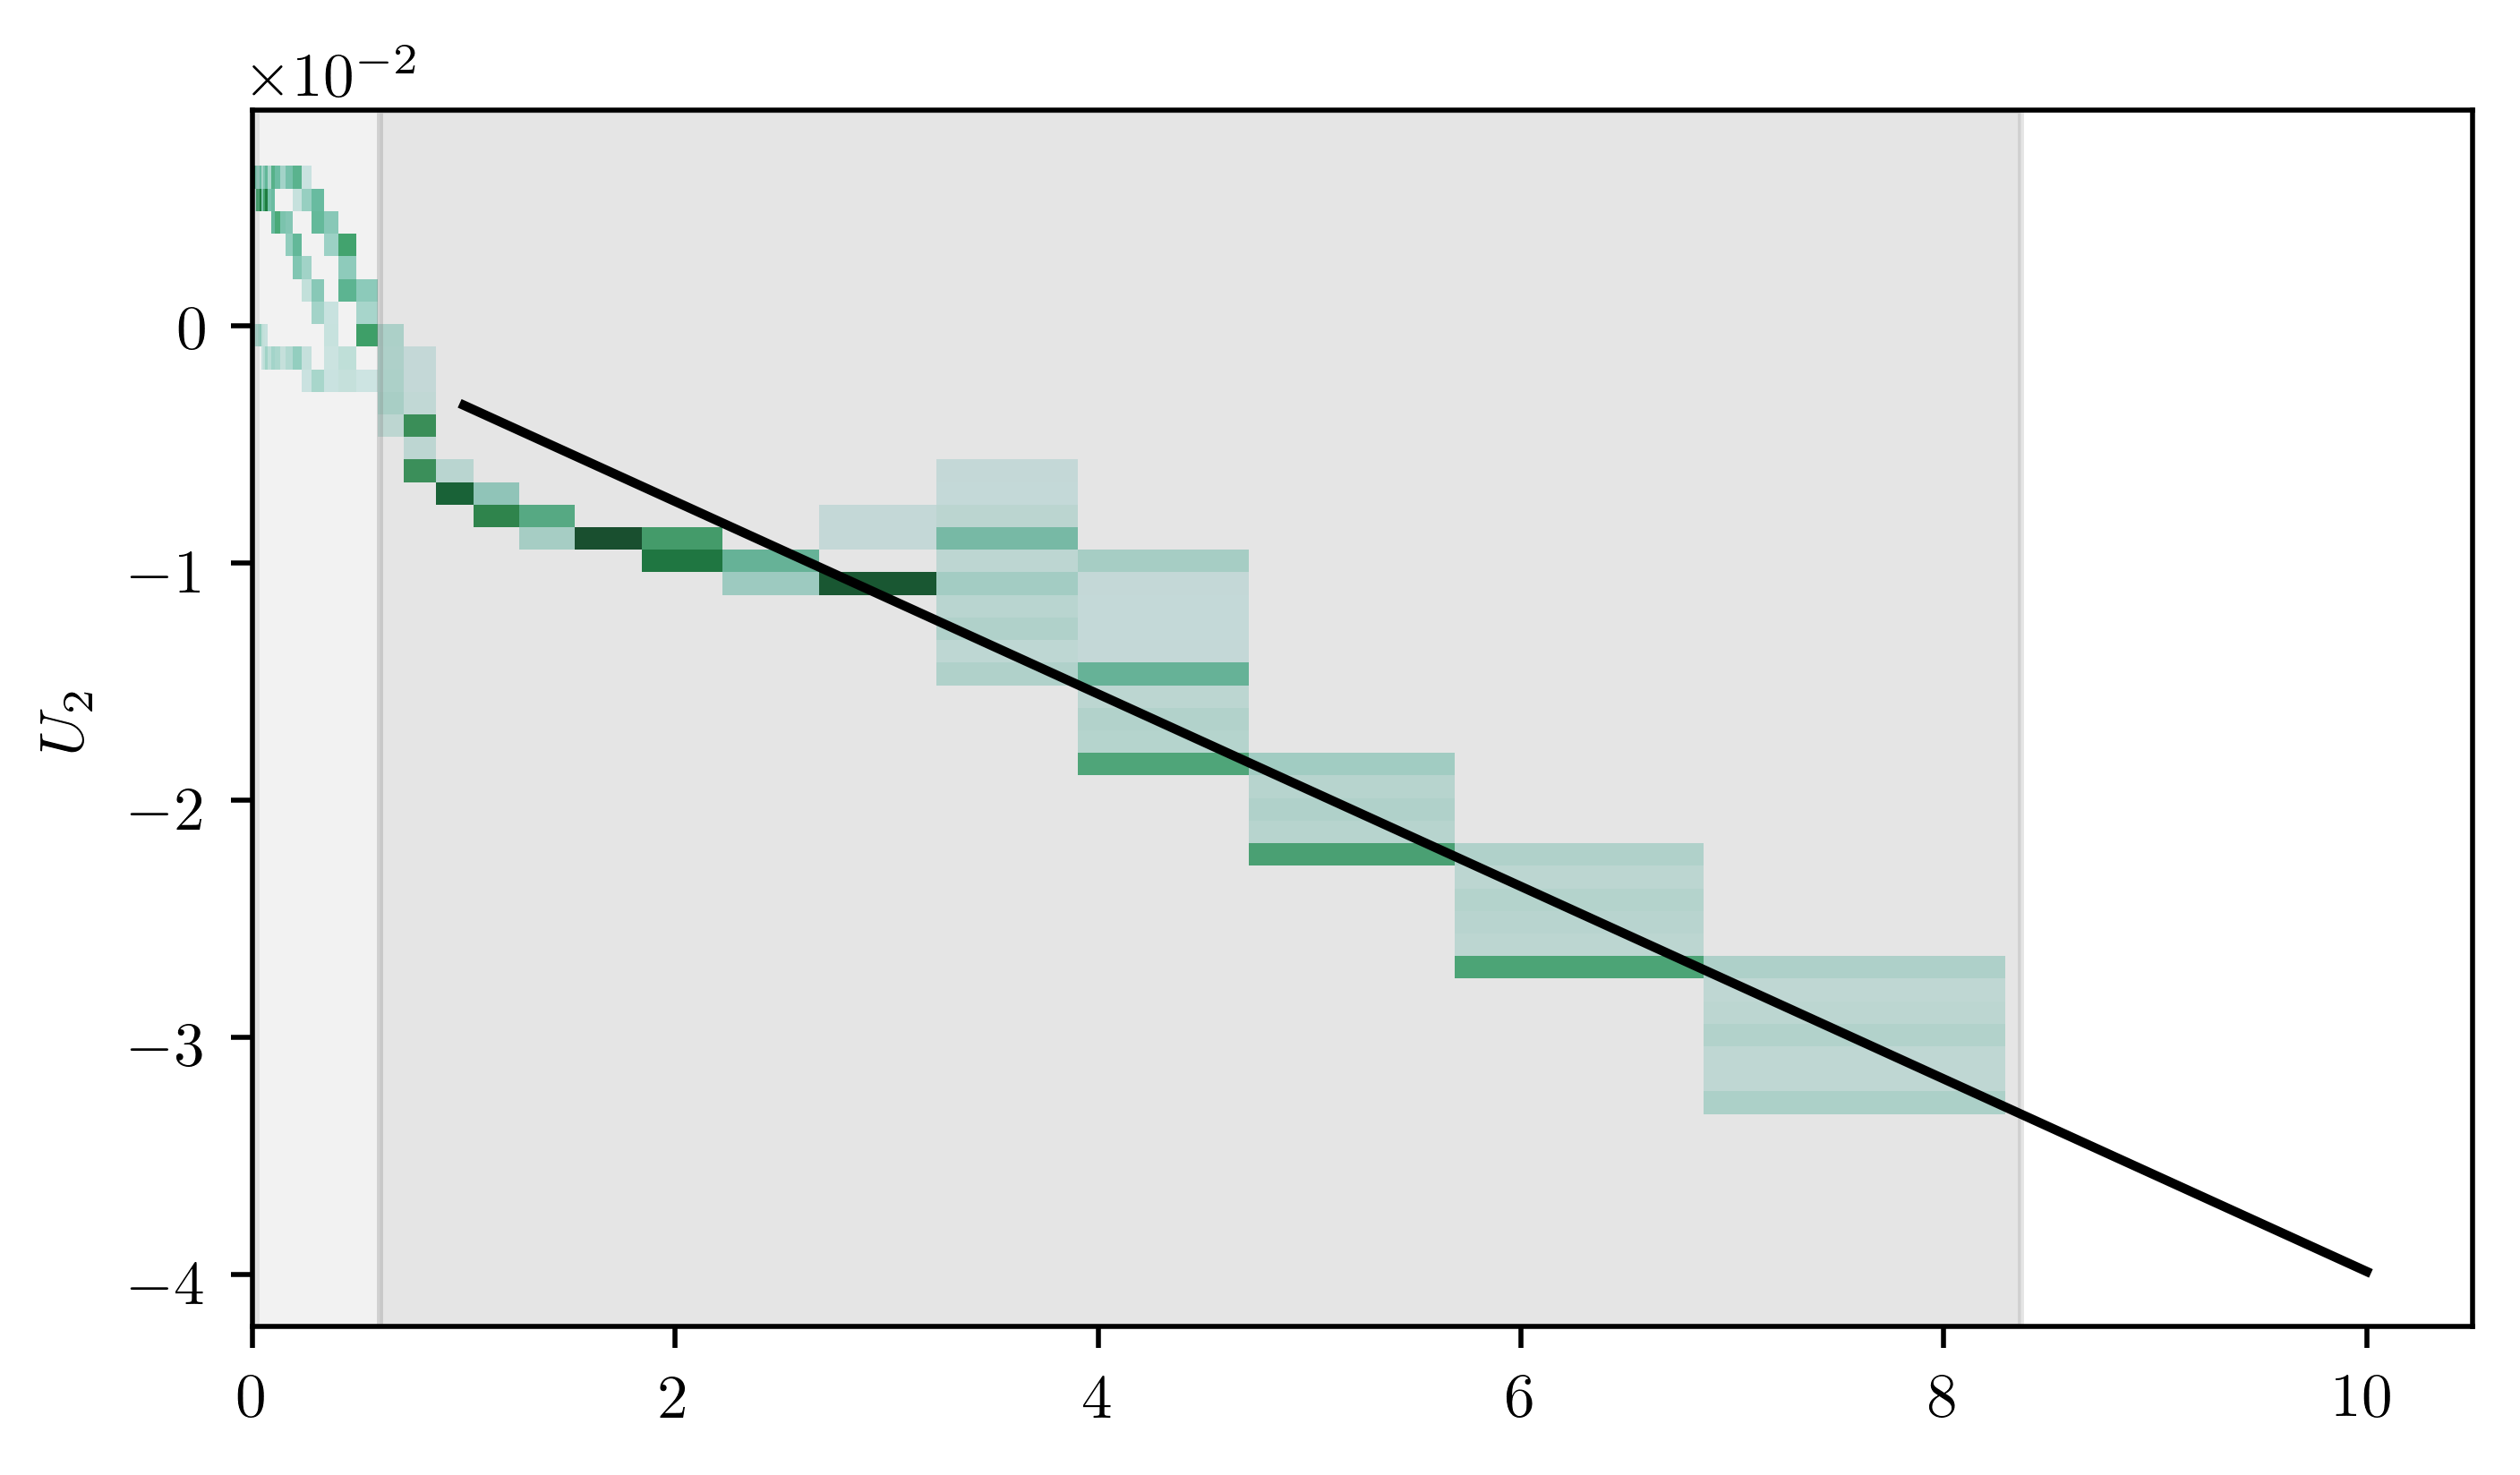

In [28]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import colorbar
from matplotlib import colors as mcolors

figsize = np.array((16, 9)) * 0.4
markersize = 6
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
tcolors = np.vstack(((1, 1, 1, 1), plt.get_cmap('BuGn')(np.linspace(0.2, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', tcolors)
# norm = mcolors.LogNorm()
norm = mcolors.Normalize(vmin=0, vmax=1)

# xlim = (-0.0001, 115)
# ylim0 = (-0.43, 0.05)
# ylim1 = (0.45, 1.02)

xlim = (-0.001, 10.5)
linthreshx, linscalex = 1e-2,  0.5
ylim0 = (-0.04221, 0.00910)
nyaxis0 = 50
ylim1 = (0.38, 1.02)
nyaxis1 = 50
ylim2 = (-0.48, 1.52)
nyaxis2 = 50
linthreshy2, linscaley2 = 0.01, 1
omega_tail_list = np.hstack((0, 10 ** np.linspace(-3, 1, 50)[:-1]))
pickle_handle_list = ['C1', 'C4b']

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')

# dy, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(dy_list[tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis0))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im0 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_xticklabels([])
axi.set_ylabel('$U_2$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim0)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
# for tpickle in pickle_list:
#     tomega_tail_list, tmean_eta_list, tdy_list = tpickle
#     axi.plot(tomega_tail_list, tdy_list, '.', markersize=markersize)
tx = np.linspace(1, 10, 30)
ty = 0.000722 + -0.004060 * tx
axi.plot(tx, ty, '-k')


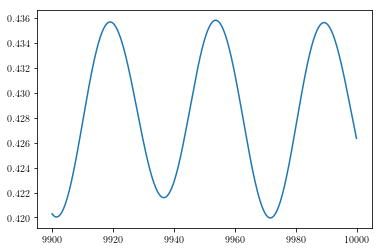

In [141]:
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_g/th2.17428_ph5.98741_ps3.66493/omega_tail00.81259_th2.174_ph5.987_ps3.665_D20200812_T210328.pickle'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th2.98297_ph4.47437_ps5.60496/omega_tail03.23746_th2.983_ph4.474_ps5.605_D20200805_T230041.pickle'
show_colorbar = False 
figsize=np.array((16, 9)) * 1
dpi=200

with open(tpath, 'rb') as handle:
    tpick = pickle.load(handle)
Table_t = tpick['Table_t']
Table_dt = tpick['Table_dt']
Table_X = tpick['Table_X']
Table_P = tpick['Table_P']
Table_P2 = tpick['Table_P2']
Table_theta = tpick['Table_theta']
Table_phi = tpick['Table_phi']
Table_psi = tpick['Table_psi']
Table_eta = tpick['Table_eta']
idx = (Table_t > 9900) * (Table_t < np.inf)
# spf_tb.show_table_result_v2(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                             Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], 
#                             figsize=figsize, dpi=dpi)
plt.plot(Table_t[idx], Table_psi[idx] / np.pi)

# idx = Table_t > 9000
# fig = plt.figure(figsize=(5, 5), dpi=300)
# spf_tb.light_show_theta_phi(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                             Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], 
#                             fig=fig, show_colorbar=show_colorbar)

In [110]:
tyerr_all.min()

5.266219635352096e-13

y = 0.000722 + -0.004060 * x in range (5.016592, 10.0)
y = -0.006427 + -0.001339 * x in range (1.000509, 3.498496)
(-0.5, 10.5) (-0.042214619578067714, 0.009102998752576811)


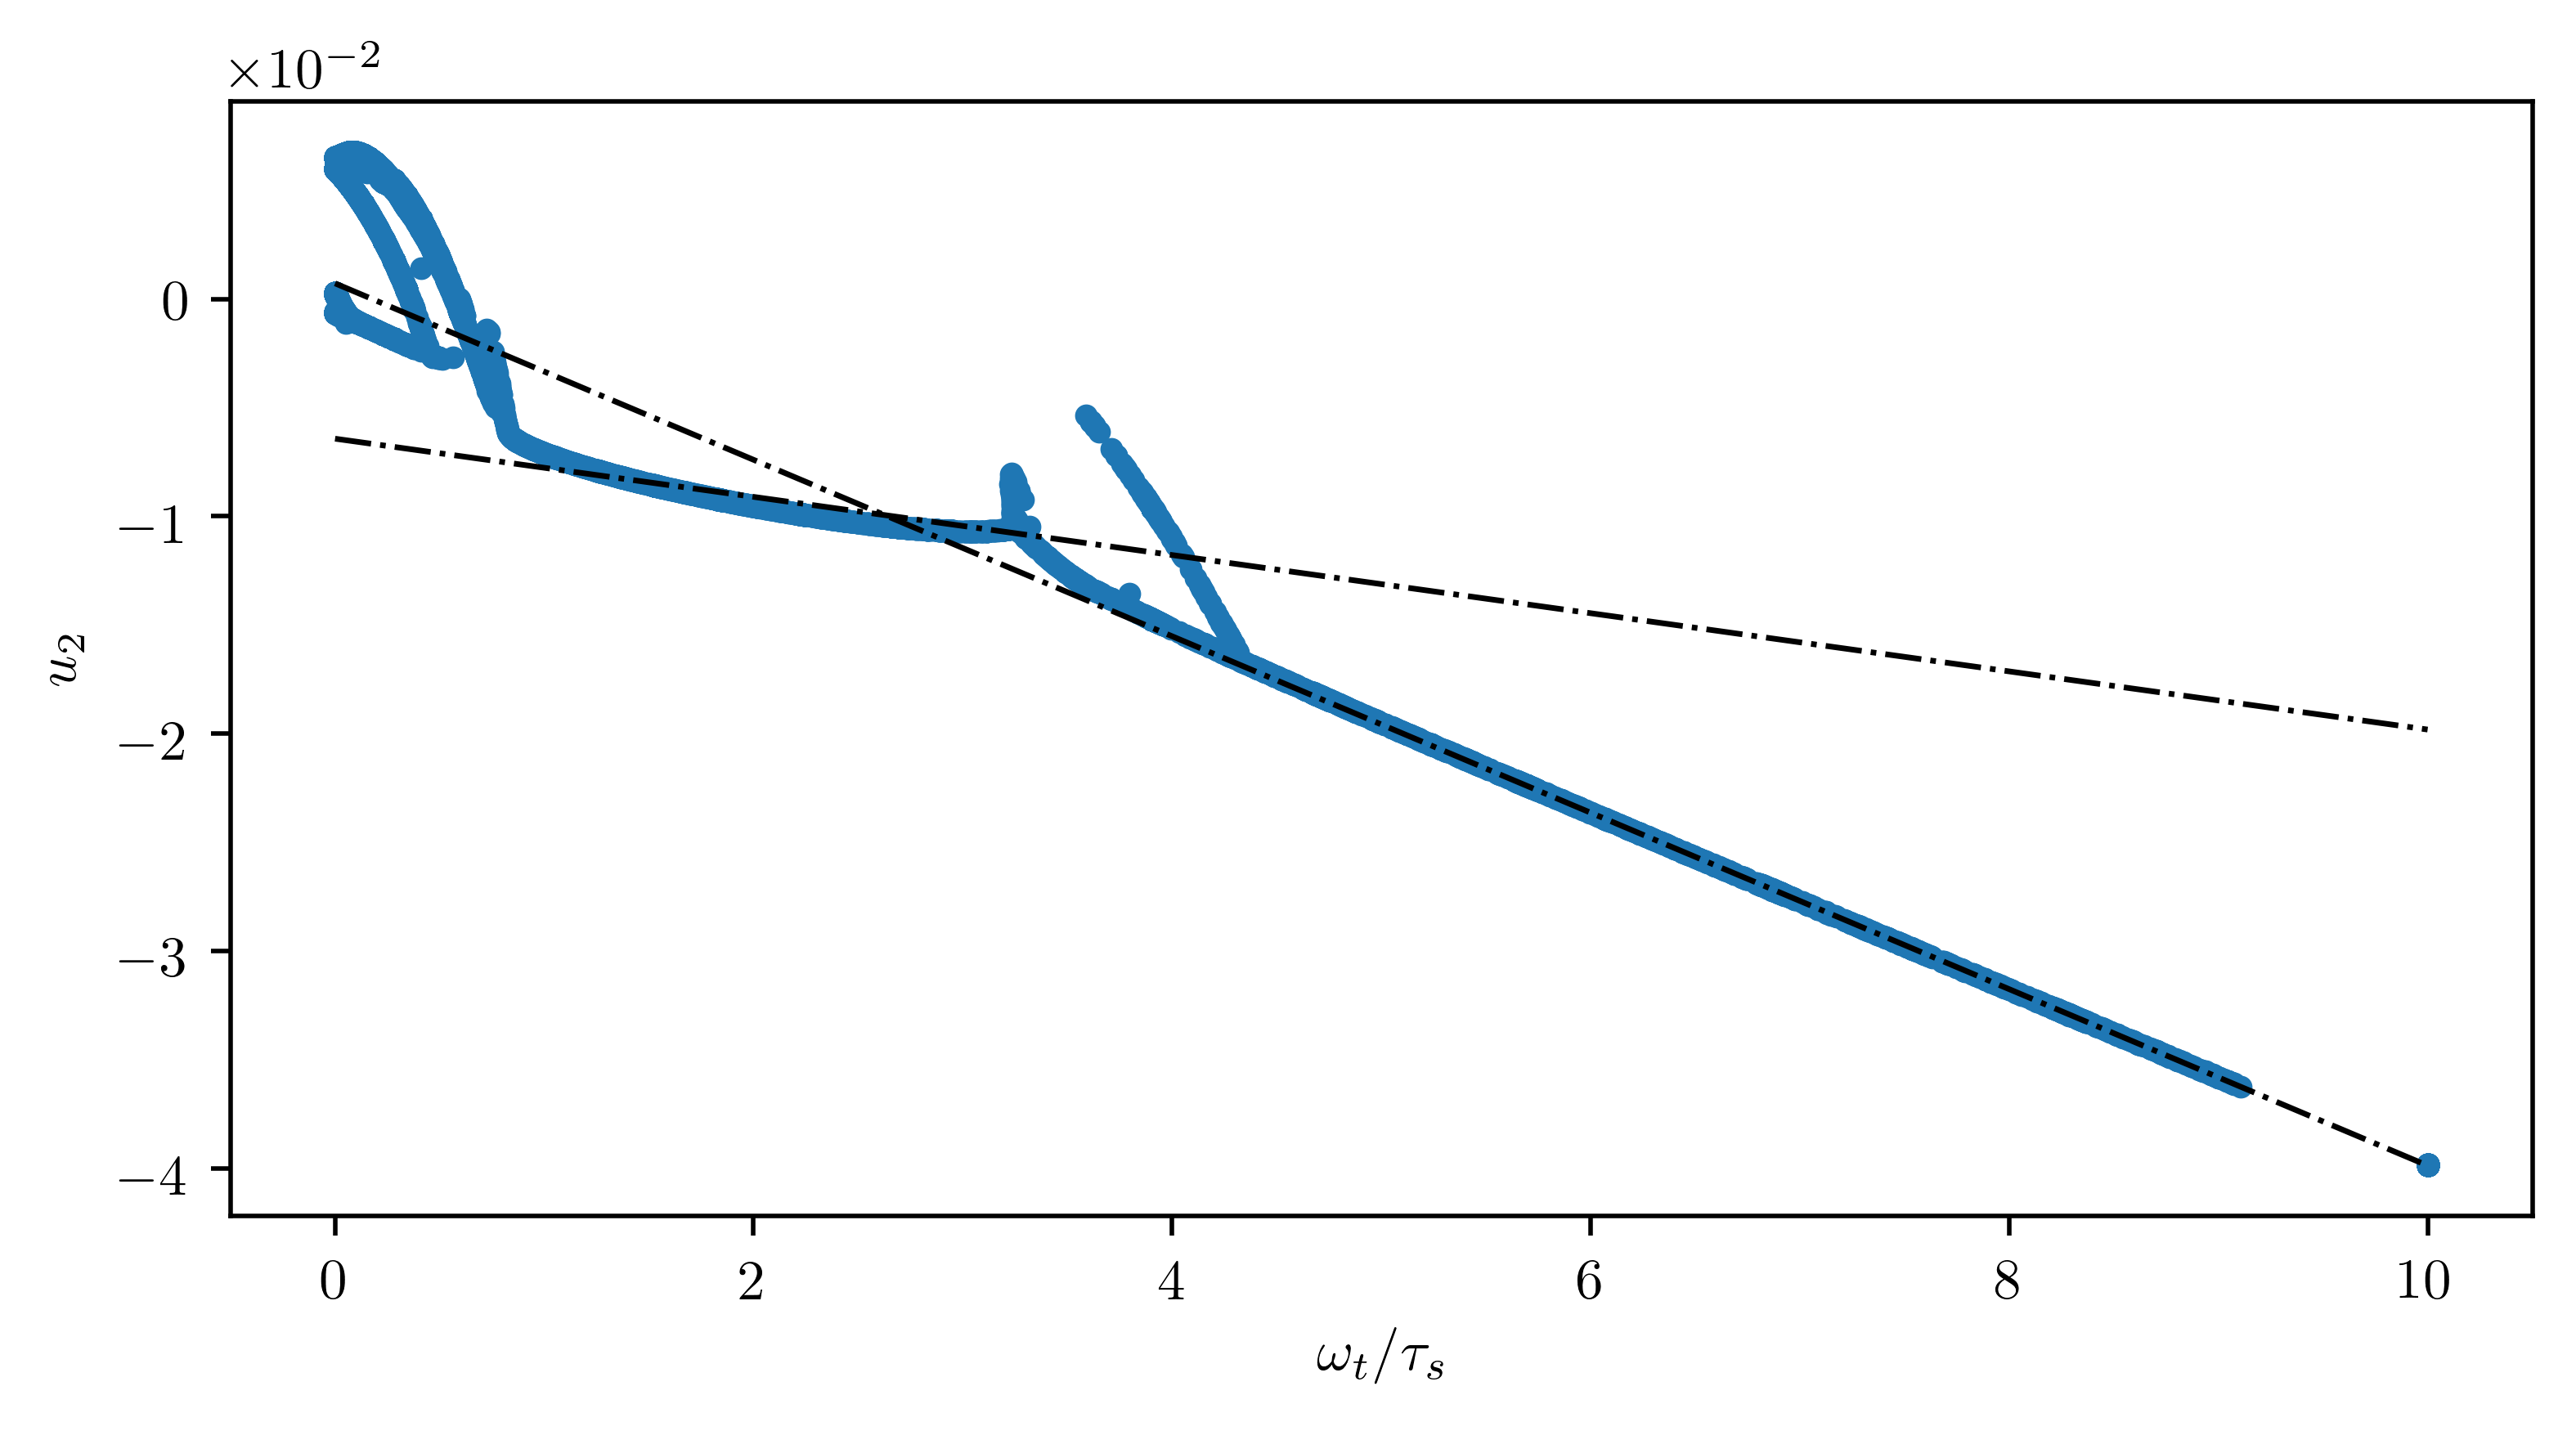

In [33]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.4
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')

wt_all = []
dy_all = []
for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    axi.plot(wt_list[tidx], dy_list[tidx], '.C0', alpha=1)
    wt_all.append(wt_list)
    dy_all.append(dy_list)
wt_all = np.hstack(wt_all)
tidx = np.argsort(wt_all)
wt_all = wt_all[tidx]
dy_list = np.hstack(dy_all)[tidx]
spf.fit_line(axi, wt_all, dy_list, 5, np.inf, extendline=True, color='k', alpha=1)
spf.fit_line(axi, wt_all, dy_list, 1, 3.5, extendline=True, color='k', alpha=1)
axi.patch.set_alpha(0)
axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_ylabel('$u_2$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.axvspan(0, 0.015, alpha=0.05, color='gray')
# axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
# axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
print(axi.get_xlim(), axi.get_ylim())
plt.tight_layout()

(-0.0004100000000000004, 16.895761786607743) (0.450762555738113, 1.0233176572262268)


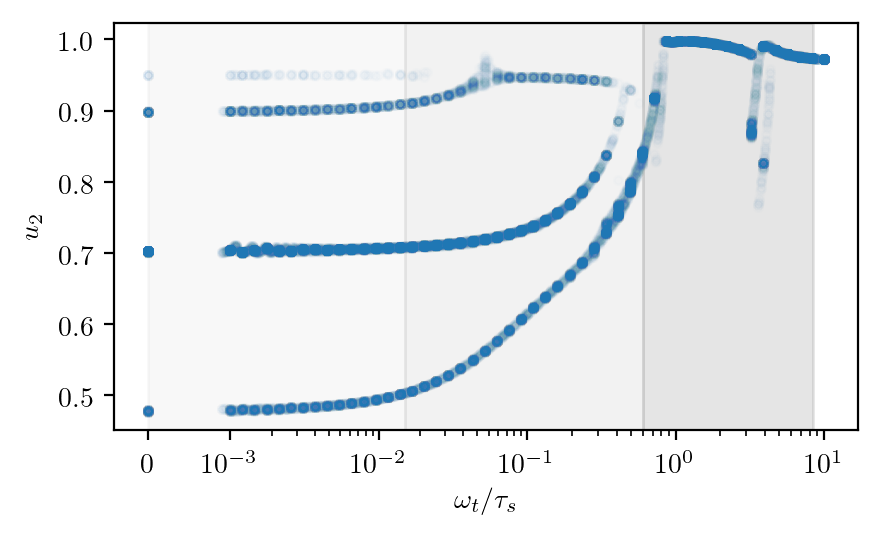

In [82]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.3
dpi = 200 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')

for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    axi.plot(wt_list[tidx], mean_eta_list[tidx] / np.pi, '.C0', alpha=0.01)
axi.patch.set_alpha(0)
axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_ylabel('$u_2$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.tick_params(axis='x', which='minor', bottom=True)
axi.xaxis.set_minor_locator(spf.MinorSymLogLocator(1e-1))
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
print(axi.get_xlim(), axi.get_ylim())

In [14]:
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle'
os.path.dirname(tpath)
# os.path.split(tpath) 
os.path.basename(os.path.dirname(tpath))

'th2.57098_ph4.45271_ps0.04594'

## special for 20200831 talk

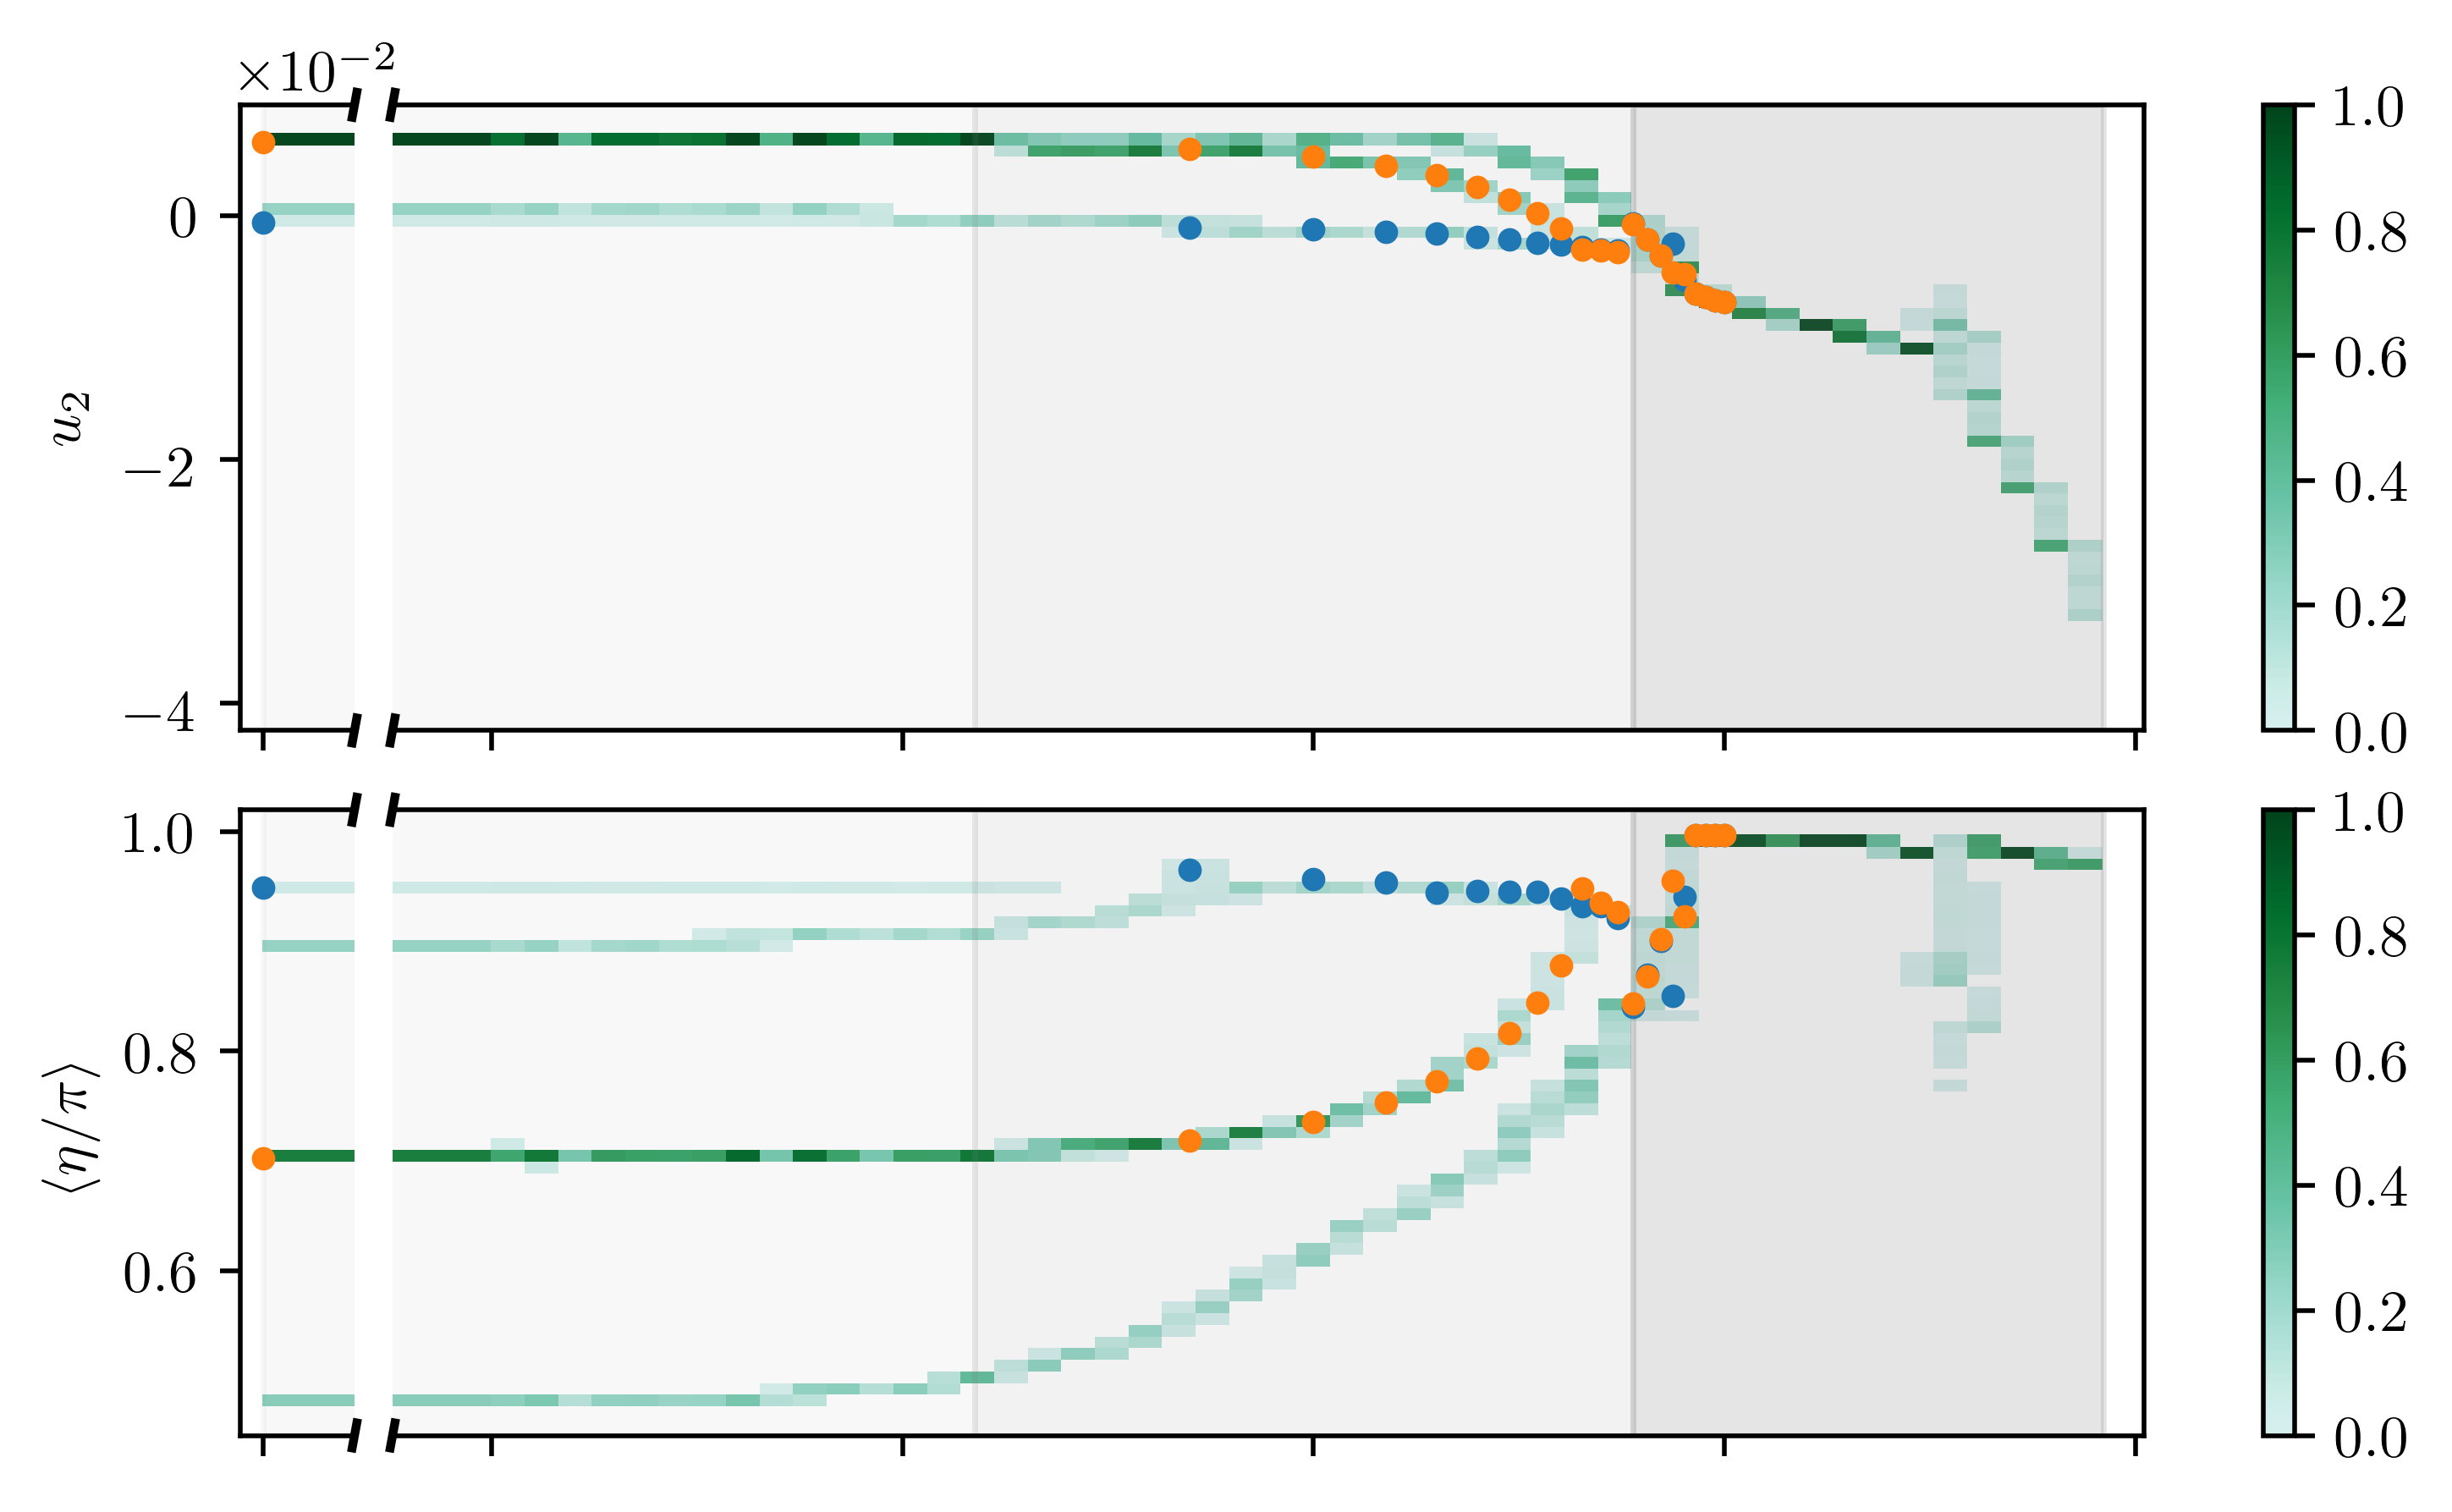

In [95]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import colorbar
from matplotlib import colors as mcolors

figsize = np.array((16, 9)) * 0.4
markersize = 6
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
tcolors = np.vstack(((1, 1, 1, 1), plt.get_cmap('BuGn')(np.linspace(0.2, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', tcolors)
# norm = mcolors.LogNorm()
norm = mcolors.Normalize(vmin=0, vmax=1)

# xlim = (-0.0001, 115)
# ylim0 = (-0.43, 0.05)
# ylim1 = (0.45, 1.02)

xlim = (-0.0001, 10.5)
linthreshx, linscalex = 1e-3,  0.5
ylim0 = (-0.04221, 0.00910)
nyaxis0 = 50
ylim1 = (0.45, 1.02)
nyaxis1 = 50
ylim2 = (-0.5, 2)
nyaxis2 = 50
linthreshy2, linscaley2 = 0.01, 1
omega_tail_list = np.hstack((0, 10 ** np.linspace(-3, 1, 50)[:-1]))
pickle_handle_list = ['C1', 'C4b']


pickle_list = []
for pickle_handle in pickle_handle_list:
    pickle_name = '%s_jmp.pickle' % pickle_handle
    with open(pickle_name, 'rb') as handle:
        pickle_list.append(pickle.load(handle))

fig, axs = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
# fig, axs = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
##########################################
axi = axs[0]
# dy, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(dy_list[tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis0))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im0 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_xticklabels([])
axi.set_ylabel('$u_2$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim0)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
for tpickle in pickle_list:
    tomega_tail_list, tmean_eta_list, tdy_list = tpickle
    axi.plot(tomega_tail_list, tdy_list, '.', markersize=markersize)
# tx = np.linspace(1, 10, 30)
# ty = tx * -4.02494122e-03
# axi.plot(tx, ty, '-k')

##########################################
axi = axs[1]
# mean_eta, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(mean_eta_list[tidx] / np.pi)
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis1))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im1 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_xticklabels([])
axi.set_ylabel('$\\langle \\eta / \\pi \\rangle$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim1)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
for tpickle in pickle_list:
    tomega_tail_list, tmean_eta_list, tdy_list = tpickle
    axi.plot(tomega_tail_list, np.array(tmean_eta_list) / np.pi, '.', markersize=markersize)

##########################################
plt.tight_layout()
# colorbar
axi = axs[0]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im0, cax=caxi)
# colorbar
axi = axs[1]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im1, cax=caxi)
# set position
axi_pos_base = axs[0].get_position().bounds
for axi in axs:
    axi_pos = axi.get_position().bounds
    tpos = (axi_pos_base[0], axi_pos[1], axi_pos_base[2], axi_pos_base[3])
    axi.set_position(tpos)

##########################################
axi = axs[0]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

##########################################
axi = axs[1]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)
          
# ##########################################
# # dashed boxes
# axi = axs[0]
# box_x, box_y = (2.4, 4.6), (-0.018, -0.003)
# axi.plot(box_x, np.ones_like(box_x) * box_y[0], '-.m')
# axi.plot(box_x, np.ones_like(box_x) * box_y[1], '-.m')
# axi.plot(np.ones_like(box_x) * box_x[0], box_y, '-.m')
# axi.plot(np.ones_like(box_x) * box_x[1], box_y, '-.m')
# # dashed boxes
# axi = axs[1]
# box_x, box_y = (2.4, 4.6), (0.7280652964174723, 1.0058249245131092)
# axi.plot(box_x, np.ones_like(box_x) * box_y[0], '-.m')
# axi.plot(box_x, np.ones_like(box_x) * box_y[1], '-.m')
# axi.plot(np.ones_like(box_x) * box_x[0], box_y, '-.m')
# axi.plot(np.ones_like(box_x) * box_x[1], box_y, '-.m')


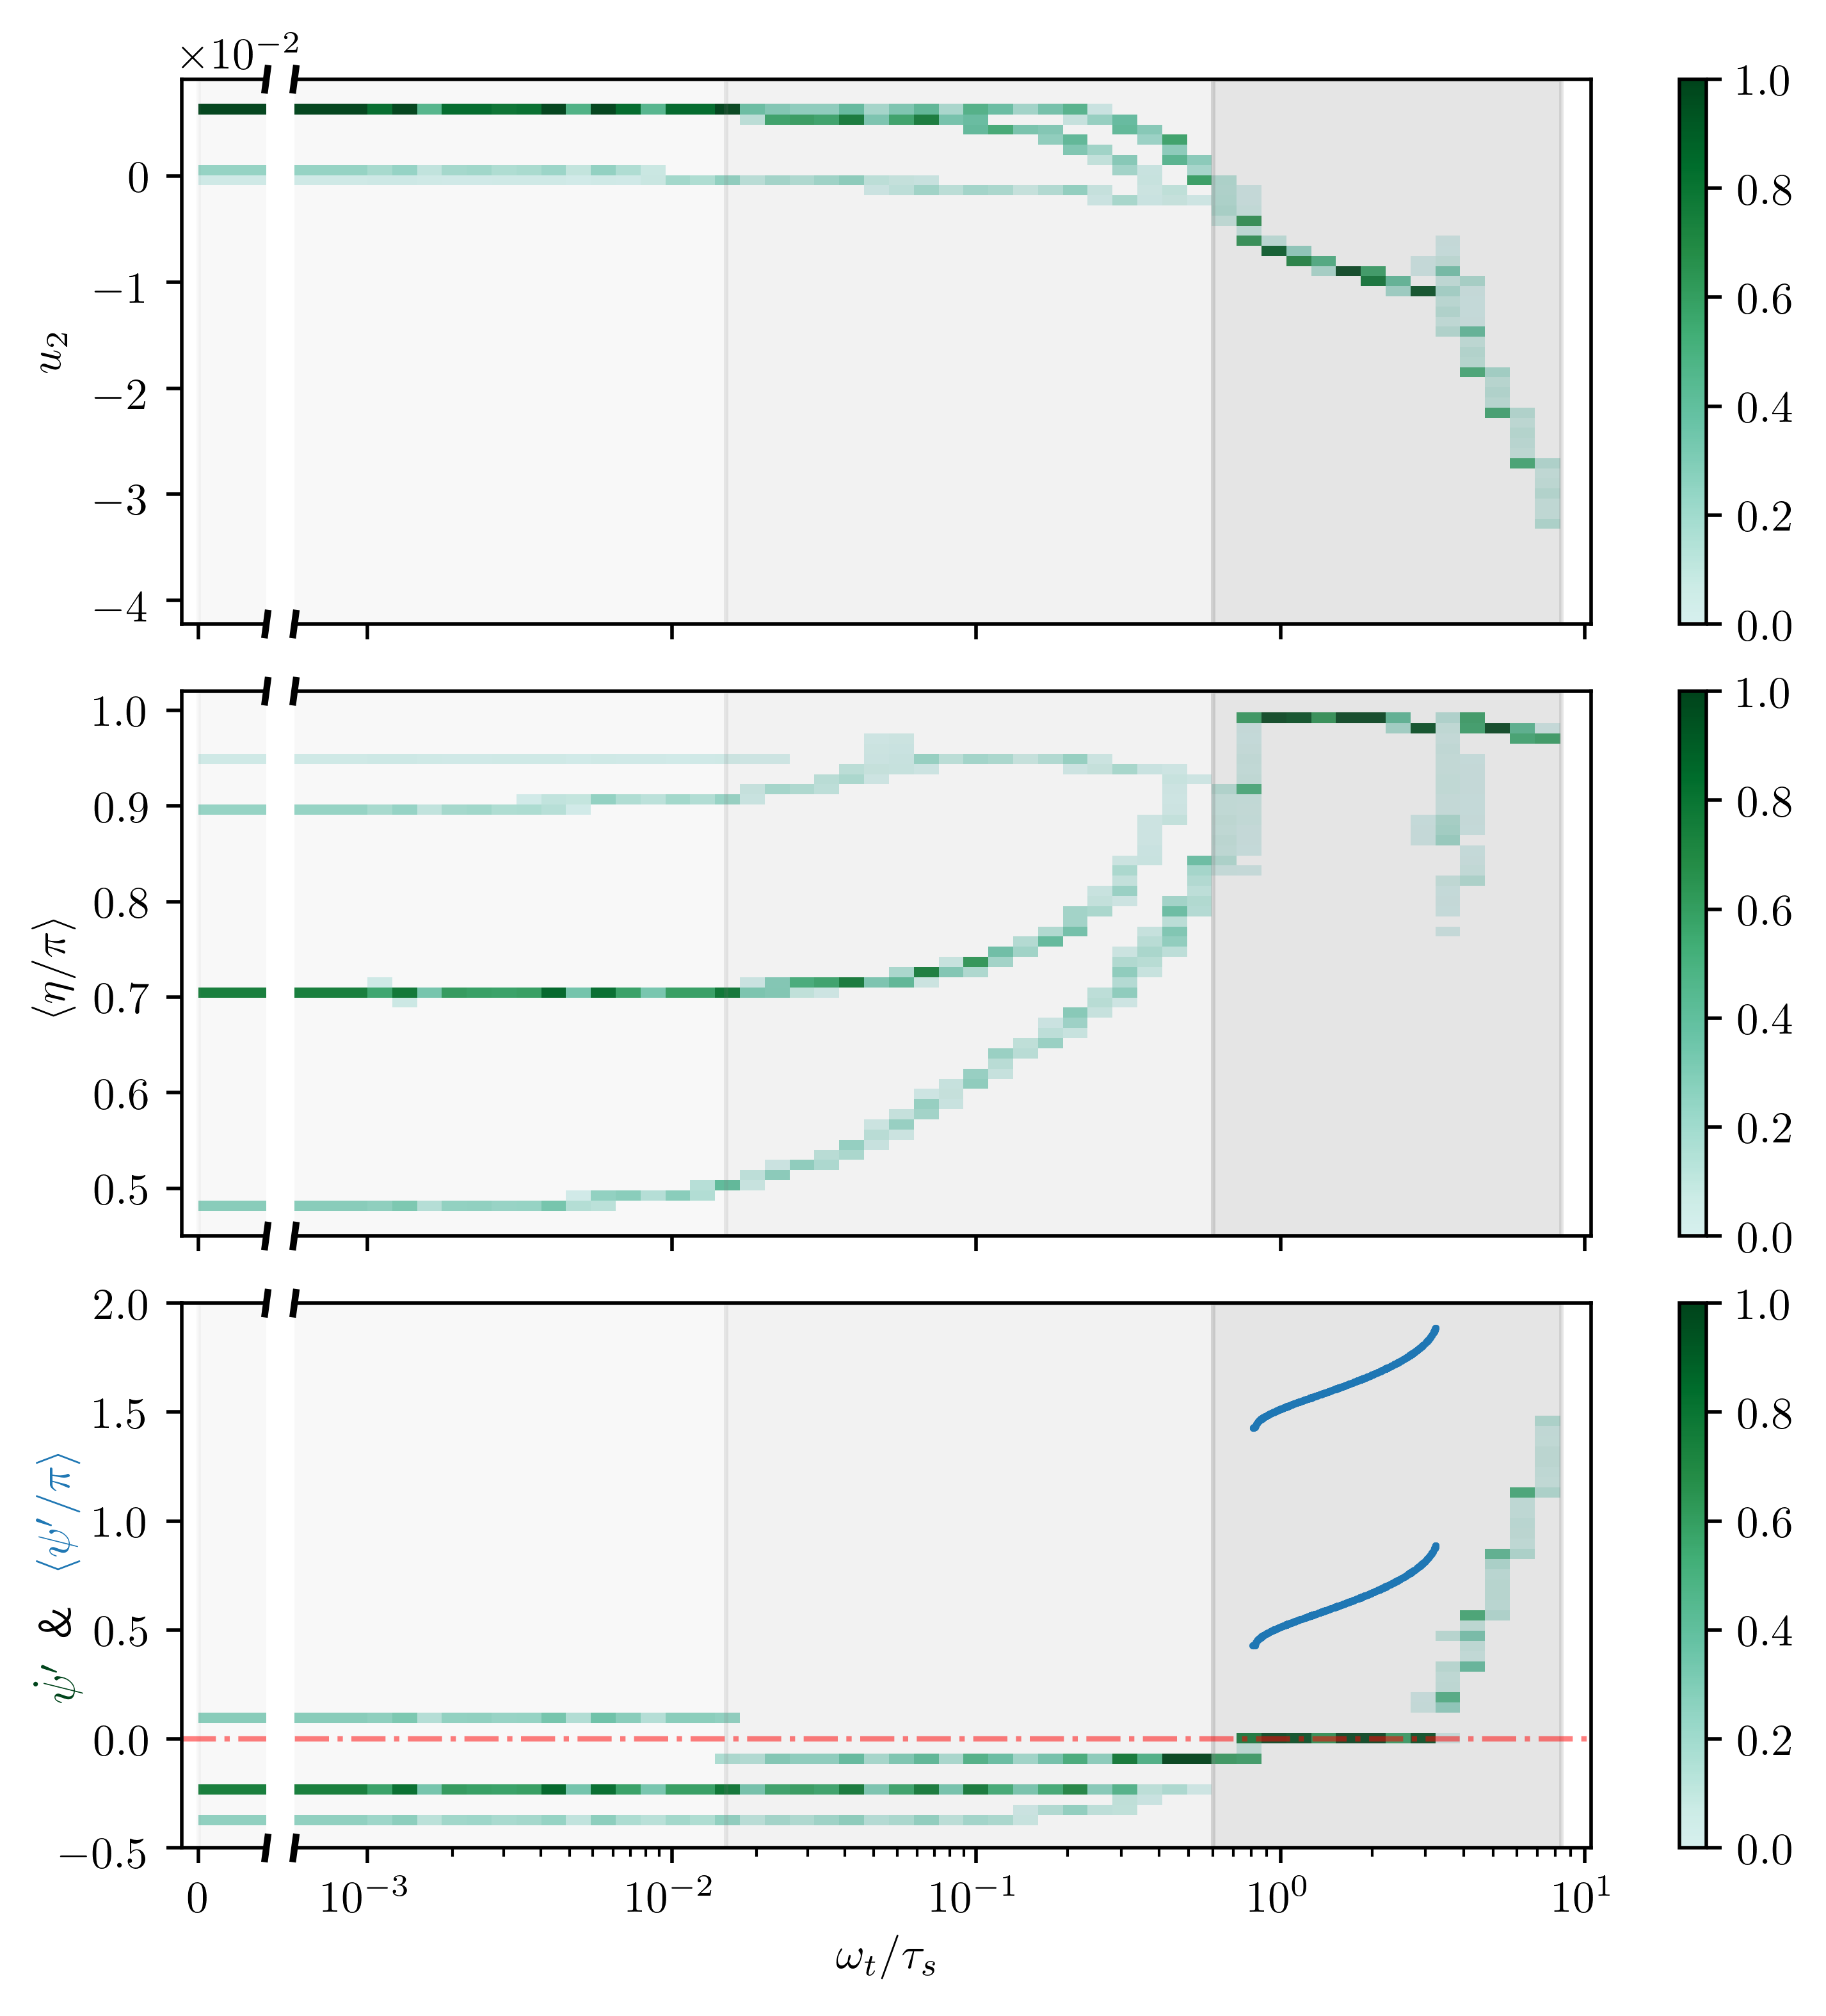

In [105]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import colorbar
from matplotlib import colors as mcolors

# figsize = np.array((16, 9)) * 0.4
figsize = np.array((16, 16)) * 0.4
markersize = 6
dpi = 500 if 'inline' in matplotlib.get_backend() else 100
tcolors = np.vstack(((1, 1, 1, 1), plt.get_cmap('BuGn')(np.linspace(0.2, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', tcolors)
# norm = mcolors.LogNorm()
norm = mcolors.Normalize(vmin=0, vmax=1)

# xlim = (-0.0001, 115)
# ylim0 = (-0.43, 0.05)
# ylim1 = (0.45, 1.02)

xlim = (-0.0001, 10.5)
linthreshx, linscalex = 1e-3,  0.5
ylim0 = (-0.04221, 0.00910)
nyaxis0 = 50
ylim1 = (0.45, 1.02)
nyaxis1 = 50
ylim2 = (-0.5, 2)
nyaxis2 = 50
linthreshy2, linscaley2 = 0.01, 1
omega_tail_list = np.hstack((0, 10 ** np.linspace(-3, 1, 50)[:-1]))
pickle_handle_list = ['C1', 'C4b']


pickle_list = []
for pickle_handle in pickle_handle_list:
    pickle_name = '%s_jmp.pickle' % pickle_handle
    with open(pickle_name, 'rb') as handle:
        pickle_list.append(pickle.load(handle))

fig, axs = plt.subplots(3, 1, figsize=figsize, dpi=dpi)
# fig, axs = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
##########################################
axi = axs[0]
# dy, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(dy_list[tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis0))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im0 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_xticklabels([])
axi.set_ylabel('$u_2$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim0)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

##########################################
axi = axs[1]
# mean_eta, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(mean_eta_list[tidx] / np.pi)
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis1))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im1 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_xticklabels([])
axi.set_ylabel('$\\langle \\eta / \\pi \\rangle$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim1)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
    
##########################################
axi = axs[2]
# version1, dpsi, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, add_info = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(add_info[1][tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis2))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im2 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.plot(xlim, np.zeros_like(xlim), '-.r', linewidth=markersize * 0.2, alpha=0.5)
# mean_psi
tx = np.hstack([i0[3] for i0 in data_list[:]])
ty = np.hstack([i0[6][0][:, 0] for i0 in data_list[:]]) / np.pi
tyerr = np.hstack([i0[6][0][:, 1] for i0 in data_list[:]]) / np.pi
tidx = tyerr < 0.1
tx = tx[tidx]
ty = ty[tidx]
axi.plot(tx, ty, '.', markersize=markersize*0.2)
# # 
# ttidx = ty < 1
# tttidx = np.argsort(tx[ttidx])
# axi.plot(tx[ttidx][tttidx][0], ty[ttidx][tttidx][0], 'sC4', markersize=markersize*0.6)
# axi.plot(tx[ttidx][tttidx][-1], ty[ttidx][tttidx][-1], '*C6', markersize=markersize*0.8)
# ttidx = ty > 1
# tttidx = np.argsort(tx[ttidx])
# axi.plot(tx[ttidx][tttidx][0], ty[ttidx][tttidx][0], 'sC4', markersize=markersize*0.6)
# axi.plot(tx[ttidx][tttidx][-1], ty[ttidx][tttidx][-1], '*C6', markersize=markersize*0.8)
# et.al. 
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.set_yscale('symlog', linthreshy=linthreshy2, linscaley=linscaley2)
axi.patch.set_alpha(0)
axi.set_xlabel('$\\omega_t / \\tau_s$')
# spf.multicolor_ylabel(axi, ('$\\dot \\psi\'$', ), (tcolors[-1], ), axis='y')
spf.multicolor_ylabel(axi, ('$\\dot \\psi\'$', '\&', '$\\langle \\psi\' / \\pi \\rangle$'), 
                      ('C0', 'k', tcolors[-1]), axis='y')
axi.set_xlim(xlim)
axi.set_ylim(ylim2)
axi.xaxis.set_minor_locator(spf.MinorSymLogLocator(1e-1))
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

##########################################
plt.tight_layout()
# colorbar
axi = axs[0]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im0, cax=caxi)
# colorbar
axi = axs[1]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im1, cax=caxi)
# colorbar
axi = axs[2]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im2, cax=caxi)
# set position
axi_pos_base = axs[0].get_position().bounds
for axi in axs:
    axi_pos = axi.get_position().bounds
    tpos = (axi_pos_base[0], axi_pos[1], axi_pos_base[2], axi_pos_base[3])
    axi.set_position(tpos)

##########################################
axi = axs[0]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

##########################################
axi = axs[1]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

##########################################
axi = axs[2]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

## sketch of $\psi'$

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle


<IPython.core.display.Javascript object>


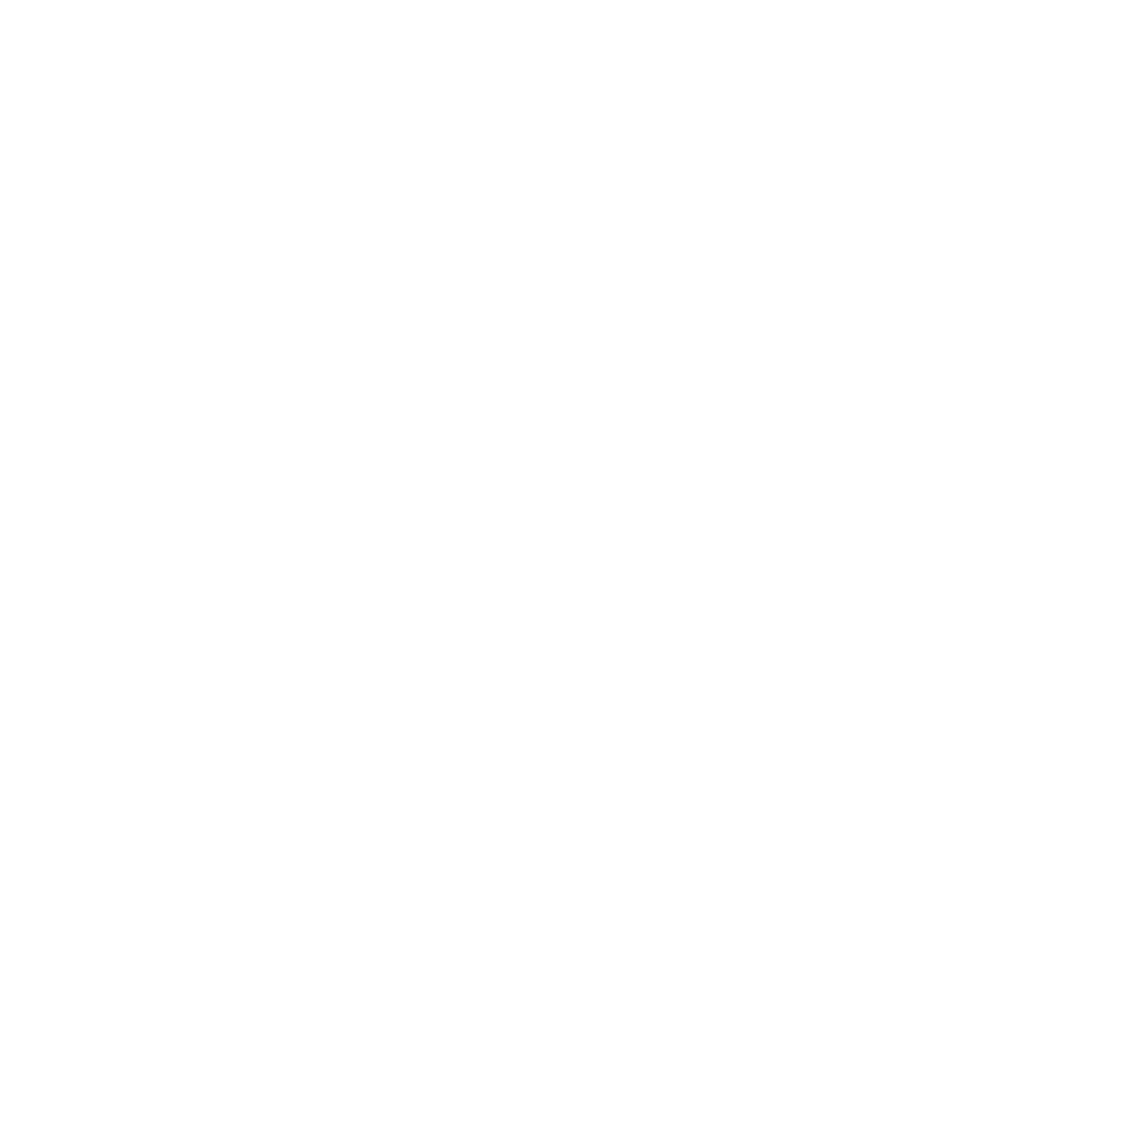

AssertionError: some objects in geo_list are not geo object. <class 'src.geo.FatHelix'>

<IPython.core.display.Javascript object>


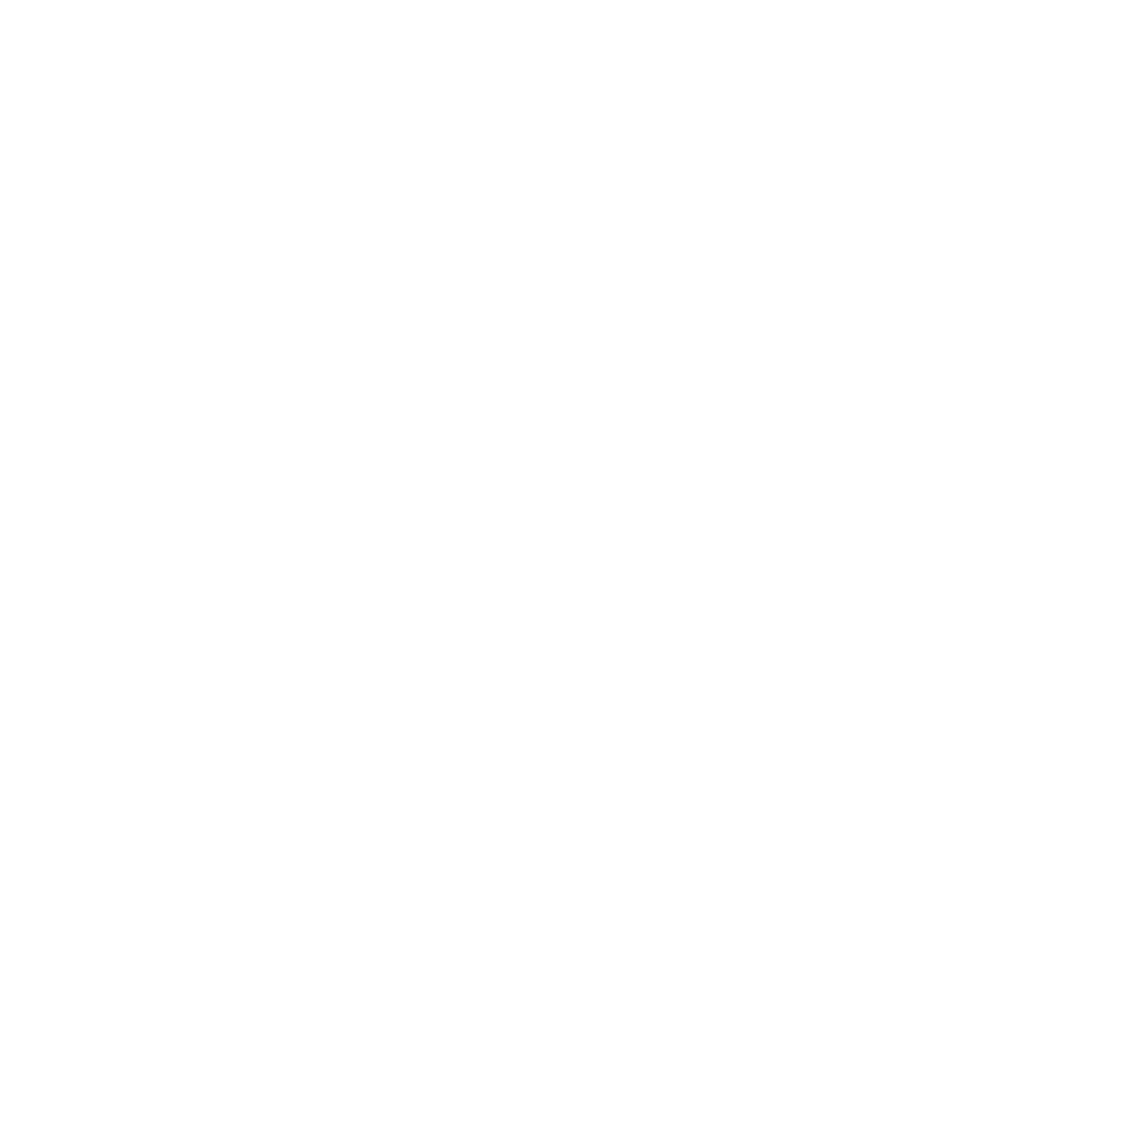

In [106]:
%matplotlib notebook
# %matplotlib inline

from src.objComposite import *
from matplotlib import colors as mcolors

figsize=np.array((9, 9))*0.4
dpi = 500 if 'inline' in matplotlib.get_backend() else 200
tmin = 9800
create_obj_at_fun = get_ecoli_nodes_split_at
extFlow = spf_tb.ext_simple_shear_flow
trange_geo = None
trange_geo = 0.3

# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle'
# color = 'C4'
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle'
color = 'C6'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_g/th2.17428_ph5.98741_ps3.66493/omega_tail00.81259_th2.174_ph5.987_ps3.665_D20200812_T210328.pickle'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th2.98297_ph4.47437_ps5.60496/omega_tail03.23746_th2.983_ph4.474_ps5.605_D20200805_T230041.pickle'

print(tpath)
with open(tpath, 'rb') as handle:
    tpick = pickle.load(handle)
Table_t = tpick['Table_t']
tidx = Table_t > tmin
# 
Table_t = tpick['Table_t'][tidx]
Table_dt = tpick['Table_dt'][tidx]
Table_X = tpick['Table_X'][tidx]
Table_P = tpick['Table_P'][tidx]
Table_P2 = tpick['Table_P2'][tidx]
Table_theta = tpick['Table_theta'][tidx]
Table_phi = tpick['Table_phi'][tidx]
Table_psi = tpick['Table_psi'][tidx]
Table_eta = tpick['Table_eta'][tidx]
table_path = os.path.join('/home/zhangji/stokes_flow_master/src', 
                          '%s.pickle' % tpick['problem_kwargs']['table_name'])
with open(table_path, 'rb') as handle:
    table_path = pickle.load(handle)
problem_kwargs = table_path['problem_kwargs']
#
# ttheta = Table_theta[0]
# tphi = Table_phi[0]
# tpsi = Table_psi[0]
# ttheta, tphi, tpsi = np.pi / 2, 3 * np.pi / 2, np.pi / 2
ttheta, tphi, tpsi = np.pi / 2, 3 * np.pi / 2, Table_psi[0]

fig, axorin = plt.subplots(1, 1, figsize=figsize, dpi=dpi, subplot_kw=dict(projection='3d'))
fig.patch.set_facecolor('white')
for spine in axorin.spines.values():
    spine.set_visible(False)
axorin.set_xlabel('$e_1$', fontsize='xx-large')
axorin.set_ylabel('$e_2$', fontsize='xx-large')
axorin.set_zlabel('$e_3$', fontsize='xx-large')
axorin.set_xticklabels([])
axorin.set_yticklabels([])
axorin.set_zticklabels([])
axorin.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axorin.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
axorin.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
# object orientation
tnodes = create_obj_at_fun(ttheta, tphi, tpsi, now_center=np.zeros(3), **problem_kwargs)
if trange_geo is None:
    tnode = np.vstack(tnodes)
    trange_geo = np.linalg.norm(tnode.max(axis=0) - tnode.min(axis=0)) * 0.4
print('trange_geo=', trange_geo)
tmid = np.zeros(3)
axorin.set_xlim3d([tmid[0] - trange_geo, tmid[0] + trange_geo])
tticks = np.around(np.linspace(tmid[0] - trange_geo, tmid[0] + trange_geo, 21),
                   decimals=2)[1::6]
axorin.set_xticks(tticks)
# axorin.set_xticklabels(tticks)
axorin.set_ylim3d([tmid[1] - trange_geo, tmid[1] + trange_geo])
tticks = np.around(np.linspace(tmid[1] - trange_geo, tmid[1] + trange_geo, 21),
                   decimals=2)[1::6]
axorin.set_yticks(tticks)
# axorin.set_yticklabels(tticks)
axorin.set_zlim3d([tmid[2] - trange_geo, tmid[2] + trange_geo])
tticks = np.around(np.linspace(tmid[2] - trange_geo, tmid[2] + trange_geo, 21),
                   decimals=2)[1::6]
axorin.set_zticks(tticks)
# axorin.set_zticklabels(tticks)
extFlow(axorin, trange_geo=trange_geo, **problem_kwargs)
# tmp_geo = []
# for tnodei in tnodes:
#     tmp_geo.append(axorin.plot(tnodei[:, 0], tnodei[:, 1], tnodei[:, 2])[0])
axorin.plot(tnodes[1][:, 0], tnodes[1][:, 1], tnodes[1][:, 2], color=color)[0]
axorin.plot(tnodes[0][:, 0], tnodes[0][:, 1], tnodes[0][:, 2], color=color)[0]

# # Jeffery sphere
# u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
# tr = np.linalg.norm(np.vstack(tnodes), axis=-1).max()
# x = np.cos(u) * np.sin(v) * tr
# y = np.sin(u) * np.sin(v) * tr
# z = np.cos(v) * tr
# color1 = plt.get_cmap('gray')(np.linspace(0.2, 0.8, 256))
# cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', color1)
# axorin.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cmap, edgecolor='none', alpha=0.1)
# axorin.plot(Table_P[:, 0] * tr, Table_P[:, 1] * tr, Table_P[:, 2] * tr, 'k')

plt.tight_layout()

In [108]:
problem_kwargs

{'MPISIZE': 24,
 'Tfct': 1,
 'basei': 1,
 'belemshandle': 'belems',
 'bnodeshandle': 'bnodes',
 'center': array([0, 0, 0]),
 'ch': 3.0,
 'dist_hs': 0.5,
 'ds': 0.023333,
 'eT': -1.0,
 'eh': -1.0,
 'es': -1.0,
 'ffweightT': 2.0,
 'ffweightx': 2.0,
 'ffweighty': 2.0,
 'ffweightz': 2.0,
 'field_range': array([[-3, -3, -3],
        [ 3,  3,  3]]),
 'fileHandle': 'ecoC01B05_baseFlow',
 'getConvergenceHistory': False,
 'hfct': 1.0,
 'int_epsabs': 1e-200,
 'int_epsrel': 1e-10,
 'int_limit': 1000,
 'left_hand': False,
 'ls': 1.0,
 'matname': 'body1',
 'matrix_method': 'pf',
 'n_grid': array([10, 10, 10]),
 'n_node_threshold': 5000,
 'n_tail': 1,
 'ntT': 20,
 'nth': 20,
 'ph': 0.666667,
 'pickProblem': False,
 'plot_geo': False,
 'precondition_method': 'none',
 'rT1': 0.2,
 'rT2': 0.03,
 'region_type': 'rectangle',
 'rel_Uh': array([0., 0., 0., 0., 0., 0.]),
 'rel_Us': array([0., 0., 0., 0., 0., 0.]),
 'repeat_n': 1,
 'restart': False,
 'rh1': 0.2,
 'rh11': 0.3,
 'rh12': 0.1,
 'rh2': 0.03,
 'ro

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle
trange_geo= 0.3


AttributeError: 'AxesSubplot' object has no attribute 'arrow3D'

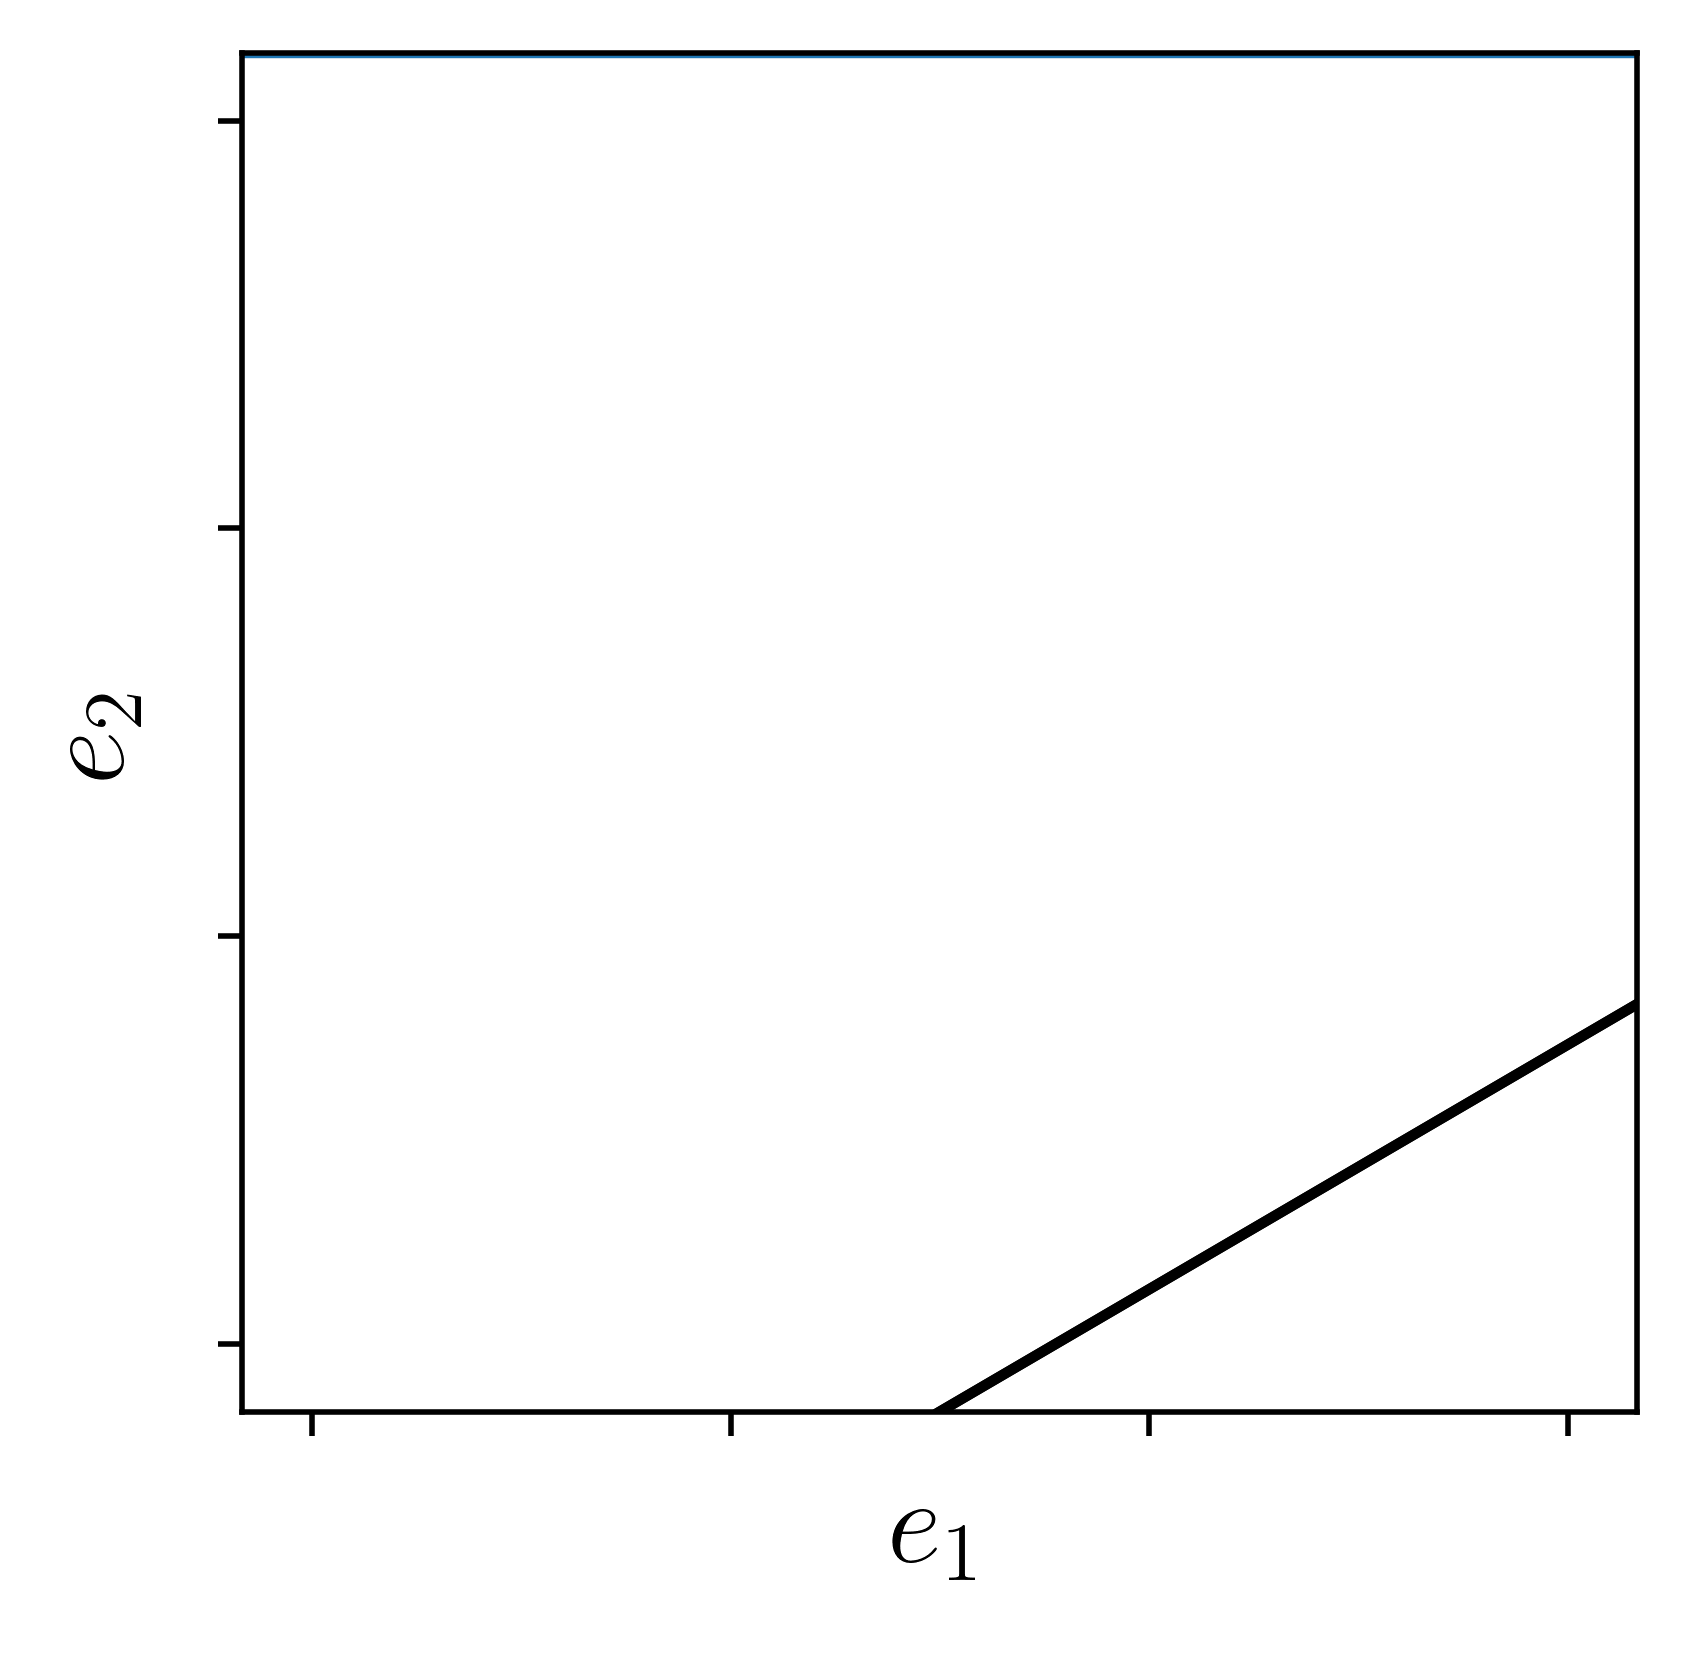

In [145]:
# %matplotlib notebook
%matplotlib inline

from src.objComposite import *
from matplotlib import colors as mcolors

figsize=np.array((9, 9))*0.4
dpi = 500 if 'inline' in matplotlib.get_backend() else 200
tmin = 9800
create_obj_at_fun = get_ecoli_nodes_split_at
extFlow = spf_tb.ext_simple_shear_flow_2D
trange_geo = None
trange_geo = 0.3

# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_h/th2.57098_ph4.45271_ps0.04594/omega_tail00.81160_th2.571_ph4.453_ps0.046_D20200813_T190350.pickle'
# color = 'C4'
tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th1.62728_ph4.98833_ps1.65852/omega_tail03.23746_th1.627_ph4.988_ps1.659_D20200805_T224544.pickle'
color = 'C6'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_g/th2.17428_ph5.98741_ps3.66493/omega_tail00.81259_th2.174_ph5.987_ps3.665_D20200812_T210328.pickle'
# tpath = '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_a/th2.98297_ph4.47437_ps5.60496/omega_tail03.23746_th2.983_ph4.474_ps5.605_D20200805_T230041.pickle'

print(tpath)
with open(tpath, 'rb') as handle:
    tpick = pickle.load(handle)
Table_t = tpick['Table_t']
tidx = Table_t > tmin
# 
Table_t = tpick['Table_t'][tidx]
Table_dt = tpick['Table_dt'][tidx]
Table_X = tpick['Table_X'][tidx]
Table_P = tpick['Table_P'][tidx]
Table_P2 = tpick['Table_P2'][tidx]
Table_theta = tpick['Table_theta'][tidx]
Table_phi = tpick['Table_phi'][tidx]
Table_psi = tpick['Table_psi'][tidx]
Table_eta = tpick['Table_eta'][tidx]
table_path = os.path.join('/home/zhangji/stokes_flow_master/src', 
                          '%s.pickle' % tpick['problem_kwargs']['table_name'])
with open(table_path, 'rb') as handle:
    table_path = pickle.load(handle)
problem_kwargs = table_path['problem_kwargs']
rh11 = problem_kwargs['rh11']
rh12 = problem_kwargs['rh12']

# fig, axorin = plt.subplots(1, 1, figsize=figsize, dpi=dpi, subplot_kw=dict(projection='3d'))
fig, axorin = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axorin.set_xlabel('$e_1$', fontsize='xx-large')
axorin.set_ylabel('$e_2$', fontsize='xx-large')
axorin.set_xticklabels([])
axorin.set_yticklabels([])
# axorin.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# axorin.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
# object orientation
rotM = spc.get_rot_matrix((0, 1, 0), np.pi/2 - Table_psi[0])
tth = np.linspace(0, 2 * np.pi, 100)
tnode = np.vstack((rh11 * np.cos(tth), np.zeros_like(tth), rh12 * np.sin(tth))).T
tnode = np.vstack([np.dot(rotM, i0) for i0 in tnode])
if trange_geo is None:
    trange_geo = np.linalg.norm(tnode.max(axis=0) - tnode.min(axis=0)) * 0.4
print('trange_geo=', trange_geo)
tmid = np.zeros(3)
axorin.set_xlim([tmid[0] - trange_geo, tmid[0] + trange_geo])
tticks = np.around(np.linspace(tmid[0] - trange_geo, tmid[0] + trange_geo, 21), decimals=2)[1::6]
axorin.set_xticks(tticks)
# axorin.set_xticklabels(tticks)
axorin.set_ylim([tmid[1] - trange_geo, tmid[1] + trange_geo])
tticks = np.around(np.linspace(tmid[1] - trange_geo, tmid[1] + trange_geo, 21), decimals=2)[1::6]
axorin.set_yticks(tticks)
# axorin.set_yticklabels(tticks)
extFlow(axorin, trange_geo=trange_geo, **problem_kwargs)
axorin.plot(tnode[:, 0], tnode[:, 2], color=color)

plt.tight_layout()

<IPython.core.display.Javascript object>


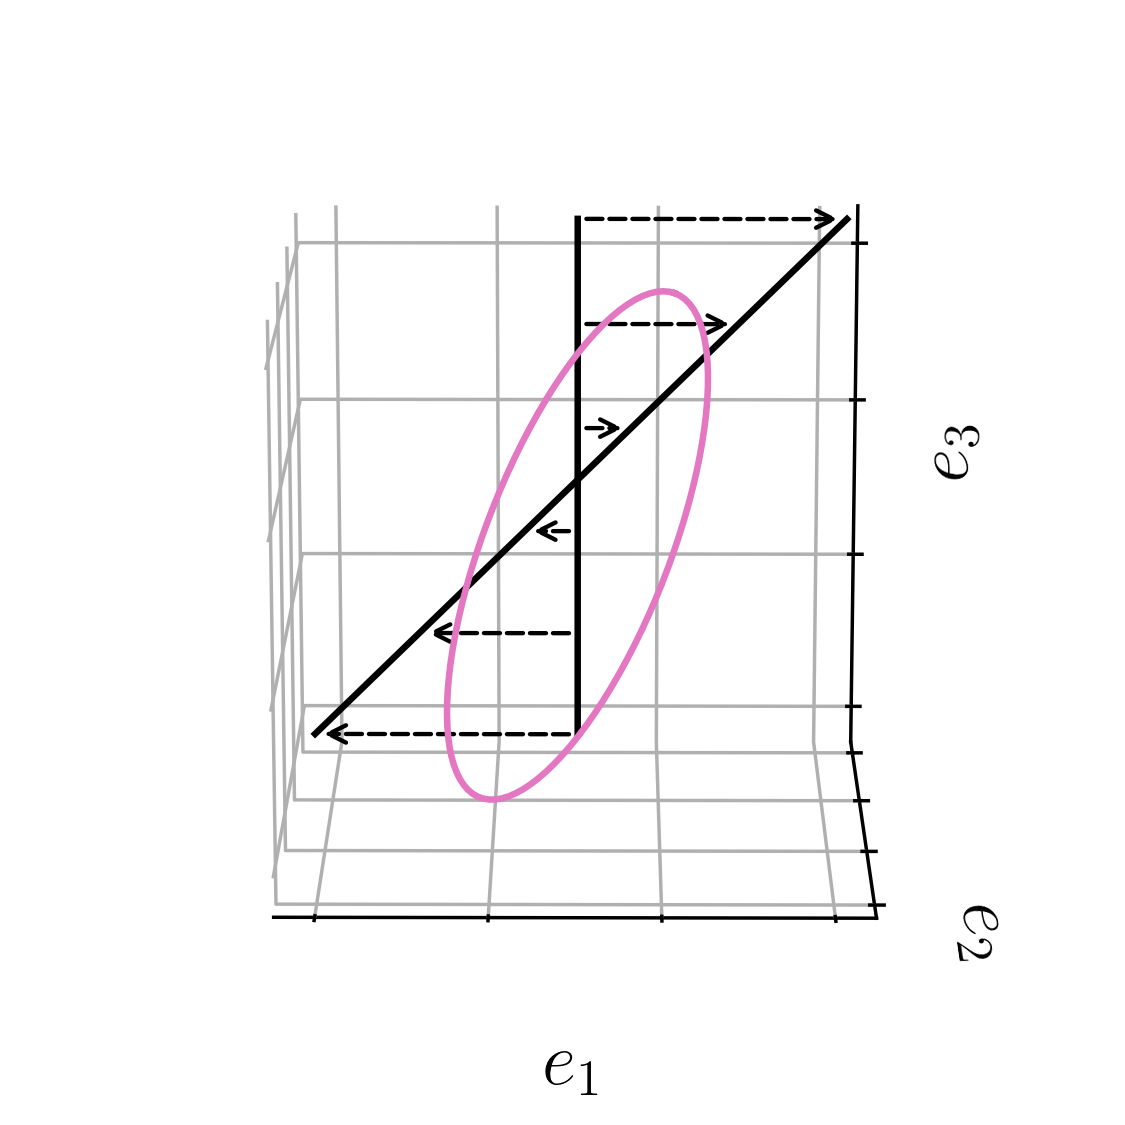

In [134]:
fig

In [128]:
from src import support_class as spc
rotM = spc.get_rot_matrix((0, 1, 0), Table_psi[0])
tth = np.linspace(0, 2 * np.pi, 100)
tnode = np.vstack((rh11 * np.cos(tth), np.zeros_like(tth), rh12 * np.sin(tth))).T
tnode = np.vstack([np.dot(rotM, i0) for i0 in tnode])
tnode

array([[-0.2811585 ,  0.        , -0.10464177],
       [-0.27838017,  0.        , -0.11037515],
       [-0.2744809 ,  0.        , -0.11566409],
       [-0.2694764 ,  0.        , -0.12048729],
       [-0.26338681,  0.        , -0.12482533],
       [-0.25623666,  0.        , -0.12866074],
       [-0.24805473,  0.        , -0.13197808],
       [-0.23887397,  0.        , -0.13476399],
       [-0.22873135,  0.        , -0.13700726],
       [-0.21766771,  0.        , -0.13869884],
       [-0.2057276 ,  0.        , -0.13983194],
       [-0.19295909,  0.        , -0.14040198],
       [-0.17941361,  0.        , -0.14040667],
       [-0.16514569,  0.        , -0.13984599],
       [-0.15021279,  0.        , -0.1387222 ],
       [-0.13467504,  0.        , -0.13703983],
       [-0.118595  ,  0.        , -0.13480565],
       [-0.10203741,  0.        , -0.13202865],
       [-0.08506896,  0.        , -0.12872002],
       [-0.06775797,  0.        , -0.12489307],
       [-0.05017413,  0.        , -0.120